In [1]:
#this file will create graphs from data in a csv file
#this data will have been compiled from many job runs
#created graphs should be saved to a folder

In [2]:
print("Code is running!")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import timeit
import os
from datetime import datetime


import glob
import os
import shutil


Code is running!


In [3]:
qm9_index_list = ['Dipole_moment', 
                  'Isotropic_polarizability',
                  'Highest_occupied_molecular_orbital_energy',
                  'Lowest_unoccupied_molecular_orbital_energy',
                  'Gap_between_previous_2',
                  'Electronic_spatial_extent',
                  'Zero_point_vibrational_energy',
                  'Internal_energy_at_0K',
                  'Internal_energy_at_298.15K',
                  'Enthalpy_at_298.15K',
                  'Free_energy_at_298.15K',
                  'Heat_capacity_at_298.15K',
                  'Atomization_energy_at_0K',
                  'Atomization_energy_at_298.15K',
                  'Atomization_enthalpy_at_298.15K',
                  'Atomization_free_energy_at_298.15K',
                  'Rotational_constant_A',
                  'Rotational_constant_B',
                  'Rotational_constant_C'
                 ]


aug_list = [0, 1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 12, 13, 14, 15, 23, 24, 
            25, 34, 35, 45, 120, 130, 140, 150, 230, 240, 250, 340, 350, 450, 123,
            124, 125, 134, 135, 145, 234, 235, 245, 345, 1230, 1240, 1250, 1340, 1350, 
            1450, 2340, 2350, 2450, 3450, 1234, 1235, 1245, 1345, 2345, 
            12340, 12350, 23450, 12345 #123450
           ]


#mean of tr set for dataset with test_train seed set to 24
mu_tr = [2.672685,
75.290359,
-6.535748,
0.323203,
6.859047,
1189.688232,
4.057997,
-11178.2207,
-11178.0459,
-11178.02051,
-11178.84961,
31.624907,
-76.127739,
-76.591614,
-77.029396,
-70.847191,
3.452992,
1.407497,
1.127863
        ]


#standard deviation of tr set for dataset with test_train seed set to 24
std_tr = [1.504563,
8.181855,
0.598676,
1.274109,
1.283764,
280.740234,
0.902004,
1085.877563,
1085.871582,
1085.871704,
1085.891235,
4.071445,
10.329565,
10.421019,
10.495149,
9.503627,
3.360785,
1.680593,
1.162036
         ]


qm9_index = {0: 'Dipole moment',
1: 'Isotropic polarizability',
2: 'Highest occupied molecular orbital energy',
3: 'Lowest unoccupied molecular orbital energy',
4: 'Gap between previous 2',
5: 'Electronic spatial extent',
6: 'Zero point vibrational energy',
7: 'Internal energy at 0K',
8: 'Internal energy at 298.15K',
9: 'Enthalpy at 298.15K',
10: 'Free energy at 298.15K',
11: 'Heat capacity at 298.15K',
12: 'Atomization energy at 0K',
13: 'Atomization energy at 298.15K',
14: 'Atomization enthalpy at 298.15K',
15: 'Atomization free energy at 298.15K',
16: 'Rotational constant A',
17: 'Rotational constant B',
18: 'Rotational constant C'}

In [4]:
#current_time = datetime.now()
#directory = current_time.strftime("%Y-%m-%d_%H_%M") + '/'
#parent_dir = '/home/ewvertina/Molecular_modelling/Experiment_Results/'
#path = os.path.join(parent_dir, directory)
#os.mkdir(path)

path = '/home/ewvertina/Molecular_modelling/Experiment_Results/2023-08-24/'
augmentations_used = '123450'
parent_dir = '/home/ewvertina/Molecular_modelling/Experiment_Results/'

In [5]:
#Moves all .csv files in Experiment_Results into the directory specified by "path"

def move_files(parent_dir, suffix):
    files = [f for f in os.listdir(parent_dir) if suffix in f.lower()]

    print("files: ", files)


    for file in files:
        new_path = path + file
        shutil.move(parent_dir + file, new_path)
        print('Moved:', file)

In [ ]:
#move_files(parent_dir, '.csv')
#move_files(parent_dir, '.png')
#move_files(parent_dir, '.txt')

In [6]:
def get_csv_df(path):
    df = pd.read_csv(path)
    if 'Augs_used' in df:
        df.rename(columns = {'Augs_used':'Augmentations_used'}, inplace = True)
    if 'Augmentations_used' in df:
        df['Augmentations_used'] = df['Augmentations_used'].astype(str)
    if 'Trial' in df:
        df['Trial'] = df['Trial'].astype(str)
        
    return df

In [7]:
#get normalized results_df
def normalizer(df, std_tr_df, metric):
    df_normalized = df.copy(deep=True)
    for feature in df:
        if feature == 'Augmentations_used' or feature == 'Trial' or feature == 'Model':
            pass
        else:
            if metric == 'mse' or feature.__contains__('mse_'):
                #print(feature.removeprefix('mse_'))
                df_normalized[feature] = df_normalized[feature].div(float(std_tr_df[feature.removeprefix('mse_')])**2)
            elif metric == 'mae' or feature.__contains__('mae_'):
                df_normalized[feature] = df_normalized[feature].div(float(std_tr_df[feature.removeprefix('mae_')]))
            else:
                #print('Possible error! Check normalizer and/or which evaluation metric used, e.g., mse')
                pass
    df_normalized = remove_outliers(df_normalized)
    return df_normalized
    #can get normalized MSE from unnormalized by dividing my standard deviation squared of training set    


In [8]:
def remove_outliers(df): #finds outliers whose normalized error is more than 10
    column_list = [feature for feature in df if feature != 'Augmentations_used' and feature != 'Trial' and feature != 'Model']
    #df.drop(columns=['B', 'C'])
    df_outlier_tf = df[column_list] > 10
    rows_to_drop = list(df_outlier_tf[df_outlier_tf.isin([True]).any(axis=1)].index.values)
    df_outliers_removed = df.drop(rows_to_drop)
    return df_outliers_removed



In [9]:
#mse_results_df = get_csv_df(path + 'results.csv')
#mse_results_df_normalized = normalizer(results_df, std_tr_df, 'mse')

#mae_results_df = get_csv_df(path + 'mae_results.csv')
#mae_results_df_normalized = normalizer(results_df, std_tr_df, 'mae')


if os.path.isfile(path + 'lm_mse.csv'): #see if the .csv file to be used already exists
    lm_mse_results_df = get_csv_df(path + 'lm_mse.csv')
    lm_mse_results_df_normalized = normalizer(lm_mse_results_df, std_tr_df, 'mse')
if os.path.isfile(path + 'lm_mae.csv'):
    lm_mae_results_df = get_csv_df(path + 'lm_mae.csv')
    lm_mae_results_df_normalized = normalizer(lm_mae_results_df, std_tr_df, 'mae')


if os.path.isfile(path + 'lgbm_mse.csv'):    
    lgbm_mse_results_df = get_csv_df(path + 'lgbm_mse.csv')
    lgbm_mse_results_df_normalized = normalizer(lgbm_mse_results_df, std_tr_df, 'mse')

if os.path.isfile(path + 'lgbm_mae.csv'):
    lgbm_mae_results_df = get_csv_df(path + 'lgbm_mae.csv')
    lgbm_mae_results_df_normalized = normalizer(lgbm_mae_results_df, std_tr_df, 'mae')

if os.path.isfile(path + 'rf_mse.csv'):
    rf_mse_results_df = get_csv_df(path + 'rf_mse.csv')
    rf_mse_results_df_normalized = normalizer(rf_mse_results_df, std_tr_df, 'mse')

if os.path.isfile(path + 'rf_mae.csv'):
    rf_mae_results_df = get_csv_df(path + 'rf_mae.csv')
    rf_mae_results_df_normalized = normalizer(rf_mae_results_df, std_tr_df, 'mae')

if os.path.isfile(path + 'xgboost_mse.csv'):
    xgboost_mse_results_df = get_csv_df(path + 'xgboost_mse.csv')
    xgboost_mse_results_df_normalized = normalizer(xgboost_mse_results_df, std_tr_df, 'mse')

if os.path.isfile(path + 'xgboost_mae.csv'):
    xgboost_mae_results_df = get_csv_df(path + 'xgboost_mae.csv')
    xgboost_mae_results_df_normalized = normalizer(xgboost_mae_results_df, std_tr_df, 'mae')









#r2_df = get_csv_df(path + 'r2.csv')

#all_trials_mse_df = get_csv_df(path + 'all_trials_mse.csv')
#all_trials_mse_df_normalized = normalizer(all_trials_mse_df, std_tr_df, 'mse')

#all_trials_mae_df = get_csv_df(path + 'all_trials_mae.csv')
#all_trials_mae_df_normalized = normalizer(all_trials_mae_df, std_tr_df, 'mae')


#all_trials_r2_df = get_csv_df(path + 'all_trials_r2.csv')












In [10]:
results_df = get_csv_df(path + 'results.csv')


In [11]:
mu_trial = results_df.mean().to_frame().T
mu_trial = mu_trial.drop(columns = ['Augmentations_used', 'Trial'])
std_trial = results_df.std().to_frame().T



/tmp/ipykernel_637742/1483642024.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mu_trial = results_df.mean().to_frame().T
/tmp/ipykernel_637742/1483642024.py:3: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  std_trial = results_df.std().to_frame().T


In [12]:
#makes pandas dataframes of the mean and std of the training set (seed 24)
mu_tr_df = pd.DataFrame()
std_tr_df = pd.DataFrame()
for feature in range(len(qm9_index_list)):
    mu_tr_df.insert(feature, str(qm9_index_list[feature]), [mu_tr[feature]])
    std_tr_df.insert(feature, str(qm9_index_list[feature]), [std_tr[feature]])
    

In [13]:
#makes pandas dataframes of the mean and std of the training set (seed 24)
mu_trial_df = pd.DataFrame()
std_trial_df = pd.DataFrame()
i = 0
for feature in results_df:
    if feature == 'Augmentations_used' or feature == 'Trial' or feature == 'Model':
        pass
    else:
        mu_trial_df.insert(i, feature, [mu_trial[feature]])
        std_trial_df.insert(i, feature, [std_trial[feature]])
        i += 1
    

In [14]:
def rename_columns(df, str_to_remove):
    column_names = {}
    for feature in df:
        if feature.__contains__(str_to_remove):
            column_names[feature] = feature.removeprefix(str_to_remove)
        else:
            column_names[feature] = feature
    df = df.rename(columns = column_names)
    return df

In [ ]:
#all_trials_mae_df_normalized_outliers_removed = remove_outliers(all_trials_mae_df_normalized)

In [ ]:
#all_trials_mae_df_normalized_outliers_removed = remove_outliers(all_trials_mae_df_normalized)

In [ ]:
#print(all_trials_mae_df_normalized_outliers_removed)

In [15]:
results_df_normalized = normalizer(results_df, std_tr_df, '')

results_df_normalized_mse = results_df_normalized.copy(deep=True)
results_df_normalized_mae = results_df_normalized.copy(deep=True)

results_df_normalized_mae = results_df_normalized_mae.drop(columns = [feature for feature in results_df_normalized_mae if ((feature.__contains__('mse_')) or (feature.__contains__('r2_')))])
results_df_normalized_mse = results_df_normalized_mse.drop(columns = [feature for feature in results_df_normalized_mse if ((feature.__contains__('mae_')) or (feature.__contains__('r2_')))])

results_df_normalized_mae = rename_columns(results_df_normalized_mae, 'mae_')
results_df_normalized_mse = rename_columns(results_df_normalized_mse, 'mse_')


In [ ]:
#finds the number of trials run per aug
#n_trials = int(max(all_trials_mae_df_normalized['Trial'].astype(float)))


In [16]:
baseline = [0.3, 0.92, 0.99, 0.87, 1.6, 0.15, 1.27, np.nan, np.nan, np.nan, np.nan,
           0.8, 0.45, 0.45, 0.39, 0.44, np.nan, np.nan, np.nan
           ]

In [17]:
baseline_df = pd.DataFrame(np.array([baseline]), columns = qm9_index_list) #from Neural Message Passing for Quantum Chemistry paper



In [18]:
#gets average performance by augmentation across all trials for that augmentation
#does this for all augmentations
def get_trial_mu_std(df):
    #print(df)
    
    avg_perf_df = pd.DataFrame(columns = [feature for feature in df])
    avg_perf_df.drop(columns=['Model', 'Trial'])
    #avg_perf_df.insert(loc=0, column = "Augmentations_used", value='')
    
    perf_std_df = pd.DataFrame(columns = [feature for feature in df])
    avg_perf_df.drop(columns=['Model', 'Trial'])
    #perf_std_df.insert(loc=0, column = "Augmentations_used", value='')
    
    for aug in aug_list:
        temp_df = pd.DataFrame(df[df['Augmentations_used'] == str(aug)])
        temp_df = temp_df.drop(columns=['Model', 'Augmentations_used', 'Trial'])
        #print('temp_df: ', temp_df)
        mu_df = temp_df.mean().to_frame().T
        #print('mu_df: ', mu_df)
        if 'Model' in mu_df:
            mu_df = mu_df.drop(columns=['Model'])
        if 'Augmentations_used' in mu_df:
            mu_df = mu_df.drop(columns=['Augmentations_used'])
        if 'Trial' in mu_df:
            mu_df = mu_df.drop(columns=['Trial'])
        
        #mu_df = mu_df.drop(columns=['Model', 'Trial'])
        mu_df.insert(loc=0, column = "Augmentations_used", value=str(aug))
        avg_perf_df = pd.concat([mu_df, avg_perf_df.loc[:]]).reset_index(drop=True)
        #print('before .dropna avg_perf_df: ', avg_perf_df)
        if 'Model' in avg_perf_df:
            avg_perf_df = avg_perf_df.drop(columns=['Model'])
        if 'Trial' in avg_perf_df:
            avg_perf_df = avg_perf_df.drop(columns=['Trial'])
        avg_perf_df = avg_perf_df.dropna()
        #print('avg_perf_df: ', avg_perf_df)
        
        
        std_df = temp_df.std().to_frame().T
        #std_df = std_df.drop(columns=['Model', 'Trial'])
        if 'Model' in std_df:
            std_df = std_df.drop(columns=['Model'])
        if 'Augmentations_used' in std_df:
            std_df = std_df.drop(columns=['Augmentations_used'])
        if 'Trial' in std_df:
            std_df = std_df.drop(columns=['Trial'])
              
        std_df.insert(loc=0, column = "Augmentations_used", value=str(aug))
        perf_std_df = pd.concat([std_df, perf_std_df.loc[:]]).reset_index(drop=True)
        #print('before dropna perf_std_df: ', perf_std_df)
        if 'Model' in perf_std_df:
            perf_std_df = perf_std_df.drop(columns=['Model'])
        if 'Trial' in perf_std_df:
            perf_std_df = perf_std_df.drop(columns=['Trial'])
        perf_std_df = perf_std_df.dropna() #drops rows with NaN, which include all aug sets with 0 and 5, and only include these sets
        #print('perf_std_df: ', perf_std_df)
        
        
    return avg_perf_df, perf_std_df



In [19]:
def graphs_by_augmentation(df, error_bars_df, augmentation, file_path, ylabel, norm):
    

    #make plots for each property
  
    for feature in df:
        if 'mse_' in feature:
            feature = feature.removeprefix('mse_')  
        if 'mae_' in feature:
            feature = feature.removeprefix('mae_')
        #the following gets average performance by aug type across the feature
        if (feature == 'Augmentations_used' or feature == 'Trial' or feature == 'Model'):
            pass
        else:     
            #print('df: ', df)
            best_idx = df[feature].idxmin()
            best_val = round(df[feature].iloc[best_idx], 3)
            best_aug = df['Augmentations_used'].iloc[best_idx]

            aug_std_idx = error_bars_df[error_bars_df["Augmentations_used"] == best_aug]
            ebar = aug_std_idx[feature]
            #print("ebar: ", ebar)
            
            plt.suptitle('Best Augmentation result for ' + feature + norm, fontsize = 10)
            plt.title('0=RWSampling 1=NodeDropping 2=NodeShuffling 3=FeatureMasking 4=FeatureDropout 5=EdgeRemoving', fontsize = 6)
            plt.ylabel(ylabel)
            plt.xlabel('Augmentation')
            
            plt.bar(best_aug, best_val, width = 0.75, color = 'blue', yerr = ebar)            
            plt.text(best_aug, 1.01*best_val, best_val, ha = 'center')
            
            baseline = baseline_df[feature]
            #print(baseline)
            plt.bar('Baseline', baseline[0], width = 0.75, color = 'orange')
            plt.text('Baseline', 1.01*baseline[0], baseline[0], ha = 'center')
            
            plt.savefig(path + ylabel + '_best_performance' + feature + '.png', format = 'png') 
            plt.show()
            plt.cla()
            
            
            
            #the following gets average performance by number of augs used
            for num_augs in range(len(augmentations_used) - 1):
                aug_by_len_df = df[df['Augmentations_used'].str.len() == (num_augs + 1)]
                if 'Model' in aug_by_len_df:
                    aug_by_len_df  = aug_by_len_df.drop(columns=['Model'])
                if 'Augmentations_used' in aug_by_len_df:
                    aug_by_len_df  = aug_by_len_df.drop(columns=['Augmentations_used'])
                if 'Trial' in aug_by_len_df:
                    aug_by_len_df  = aug_by_len_df.drop(columns=['Trial'])
                
                feature_mean = aug_by_len_df[feature].mean()
                
                if feature_mean > 1:
                    feature_mean = round(feature_mean, 2)
                elif feature_mean > 0.01:
                    feature_mean = round(feature_mean, 3)
                else:
                    feature_mean = round(feature_mean, 5)
                      
                std_df = aug_by_len_df.std().to_frame().T
                aug_by_len_df = std_df[feature]
              

                plt.suptitle(feature + norm + ' number of augmentations used ', fontsize = 10)
                plt.ylabel(ylabel)
                plt.xlabel('Number of Augmentations used')
                plt.bar(str(num_augs + 1), feature_mean, width = 0.75, color = 'blue', yerr =  aug_by_len_df)            
                plt.text(str(num_augs + 1), 1.01*feature_mean, feature_mean, ha = 'center')
                             
            plt.savefig(path + ylabel + '_avg_performance_num_augs_' + feature + '.png', format = 'png')    
            plt.show()
            plt.cla()
            
                        
                      
            #the following gets average performance by aug type across the feature
            plt.suptitle('Average ' + ylabel + ' by augmentation type for ' + feature)
            plt.ylabel(ylabel)
            plt.xlabel(' 1=NodeDropping 2=NodeShuffling 3=FeatureMasking 4=FeatureDropout 5=EdgeRemoving 0=RWSampling', fontsize = 6)
            
            for char in augmentation:
                newdf = df[df['Augmentations_used'].str.contains(char)]
                if 'Model' in newdf :
                    newdf  = newdf.drop(columns=['Model'])
                if 'Augmentations_used' in newdf :
                    newdf  = newdf.drop(columns=['Augmentations_used'])
                if 'Trial' in newdf :
                    newdf  = newdf.drop(columns=['Trial'])
                feature_mean = newdf[feature].mean()
                
                if feature_mean > 1:
                    feature_mean = round(feature_mean, 2)
                elif feature_mean > 0.01:
                    feature_mean = round(feature_mean, 3)
                else:
                    feature_mean = round(feature_mean, 5)
                
                #put error bars in next line                
                #need to combine variances squared, then take sq root, finally, divide by 
                # the number of trials
                #names_df = newdf[['Augmentations_used', 'Trial']]
                
                std_df = newdf.std().to_frame().T
                newdf = std_df[feature]
                #newdf = newdf.drop(['Augmentations_used', 'Trial'], axis = 1)
                #newdf = np.square(newdf[feature])
                #newdf = newdf.sum()
                #newdf = np.sqrt(newdf)
                #std_dev = newdf/n_trials

                plt.bar(char, feature_mean, width = 0.75, color = 'blue', yerr = newdf)            
                plt.text(char, 1.01*feature_mean, feature_mean, ha = 'center')

            #uncomment this line when running experiments
            plt.savefig(path + ylabel + '_avg_aug_performance_by_' + feature + '.png', format = 'png')
            plt.show()
            plt.cla()
                        
            
    return "Hi!"


In [20]:
def graphs_by_num_augs(df, augmentation, file_path, ylabel, norm):
    sum_performance_dict = dict.fromkeys([i for i in range(len(augmentation))], 0) #initialize dict of augs with all values set to 0

    for feature in df:
        if (feature == 'Augmentations_used'):
            pass
        else:      
            for num_augs in range(len(augmentation)):
                newdf = df[df['Augmentations_used'] == num_augs]
                sum_performance_dict[num_augs] += newdf[feature].mean()


    for key in sum_performance_dict:
        sum_performance_dict[key] = sum_performance_dict[key]/len(qm9_index_list)

        
    plt.suptitle('Avg. Aug' + ylabel + 'across all targets' + norm, fontsize = 10)
    plt.title('0=RWSampling 1=NodeDropping 2=NodeShuffling 3=FeatureMasking 4=FeatureDropout 5=EdgeRemoving', fontsize = 6)
    plt.ylabel(ylabel)
    plt.xlabel('Augmentation')
    
    names = list(sum_performance_dict.keys())
    values = list(sum_performance_dict.values())
    
    #put error bars in next line
    plt.bar(range(len(sum_performance_dict)), values, tick_label = names, width = 0.75, color = 'blue')            
    for i in range(len(augmentations_used)):
        plt.text(i, values[i], round(values[i], 2), ha='center', va='bottom')

    #uncomment this line when running experiments
    #plt.savefig(path + 'avg_performance_num_augs' + '.png', format = 'png')
    plt.show()
    #plt.cla()

In [21]:
def avg_by_augmentation_graph(df, augmentation, file_path, ylabel, norm):
    trial_mu_df, error_bars_df = get_trial_mu_std(df)

    if norm == '_normalized':
        error_bars_df = normalizer(error_bars_df, std_tr_df, ylabel.lower())
    
    graphs_by_augmentation(df, error_bars_df, augmentation, file_path, ylabel, norm)
    #graphs_by_num_augs(df, augmentation, file_path, ylabel, norm)
    
    #make single plot
    #since all features are normalized, we can just take average performance across all targets
    sum_performance_dict = dict.fromkeys([i for i in augmentations_used], 0) #initialize dict of augs with all values set to 0

    for feature in df:
        if feature == 'Augmentations_used' or feature == 'Trial' or feature == 'Model':
            pass
        else:      
            for char in augmentation:
                newdf = df[df['Augmentations_used'].str.contains(char)]
                if 'Model' in newdf:
                    newdf  = newdf.drop(columns=['Model'])
                if 'Augmentations_used' in newdf :
                    newdf  = newdf.drop(columns=['Augmentations_used'])
                if 'Trial' in newdf:
                    newdf  = newdf.drop(columns=['Trial'])
                sum_performance_dict[char] += newdf[feature].mean()


    for key in sum_performance_dict:
        sum_performance_dict[key] = sum_performance_dict[key]/len(qm9_index_list)

        
    plt.suptitle('Avg. Aug' + ylabel + 'across all targets' + norm, fontsize = 10)
    plt.title('0=RWSampling 1=NodeDropping 2=NodeShuffling 3=FeatureMasking 4=FeatureDropout 5=EdgeRemoving', fontsize = 6)
    plt.ylabel(ylabel)
    plt.xlabel('Augmentation')
    
    names = list(sum_performance_dict.keys())
    values = list(sum_performance_dict.values())
    
    #put error bars in next line
    plt.bar(range(len(sum_performance_dict)), values, tick_label = names, width = 0.75, color = 'blue')            
    for i in range(len(augmentations_used)):
        plt.text(i, values[i], round(values[i], 2), ha='center', va='bottom')

    #uncomment this line when running experiments
    #plt.savefig(path + 'avg_aug_performance_all' + '.png', format = 'png')
    plt.show()
    #plt.cla()
            
    return "Finished running avg_by_augmentation_graph!"

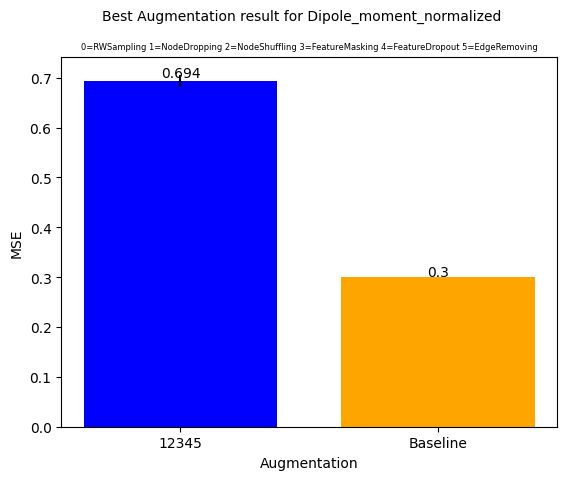

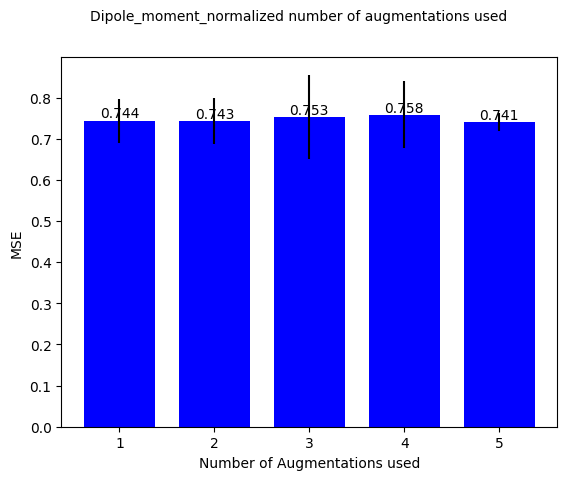

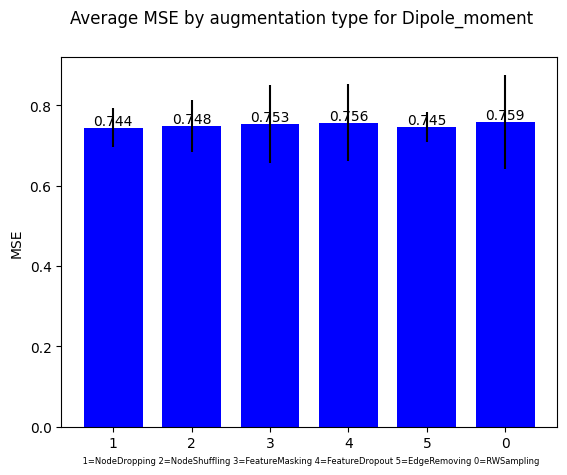

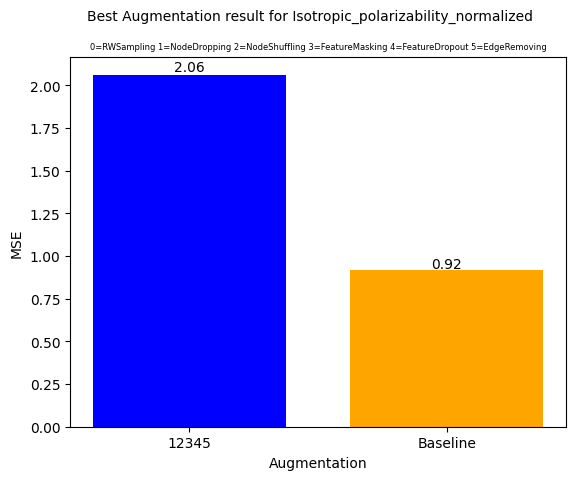

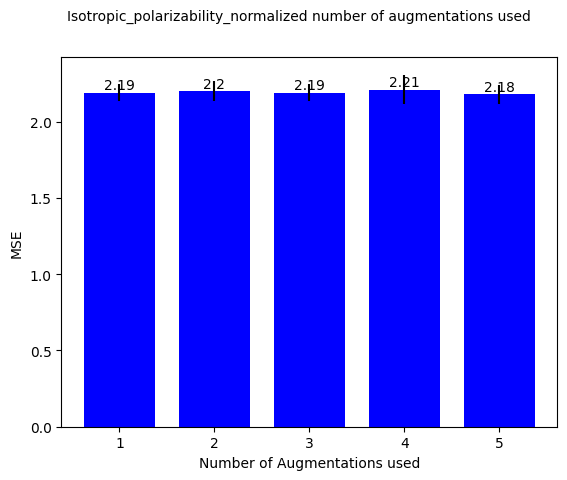

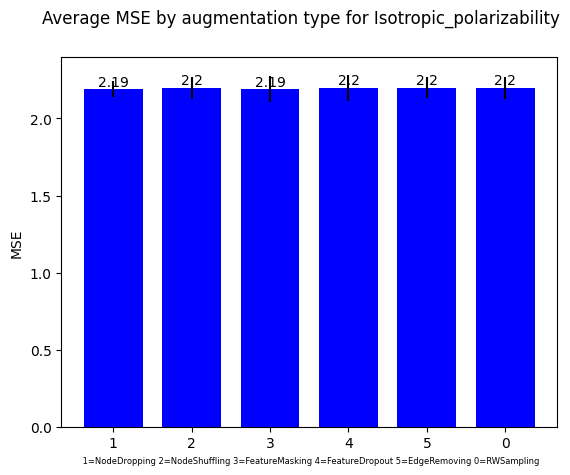

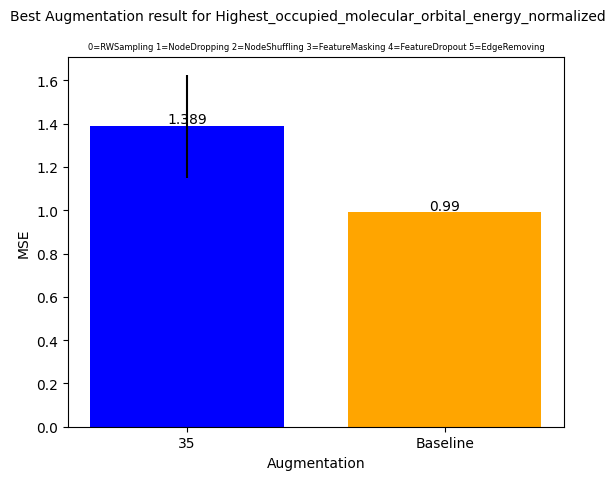

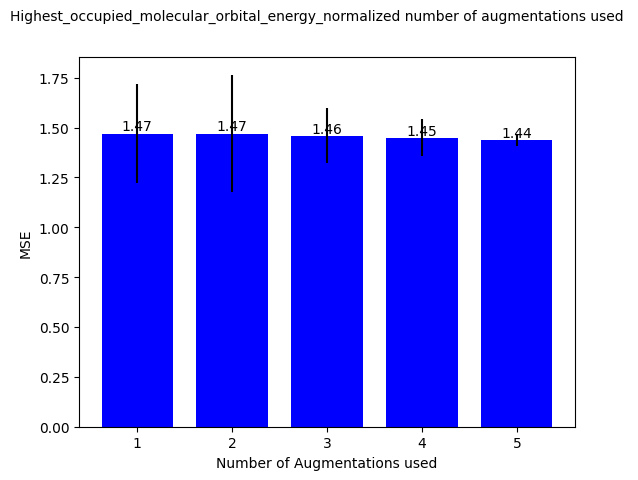

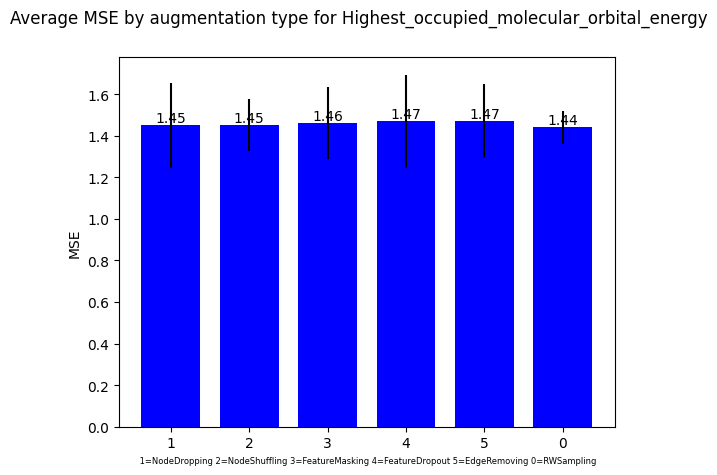

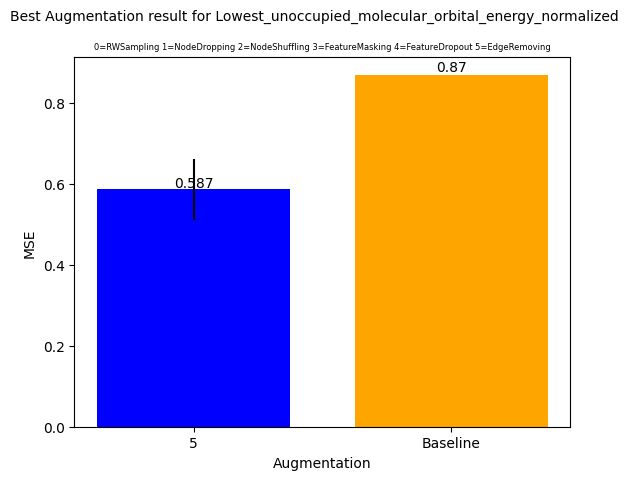

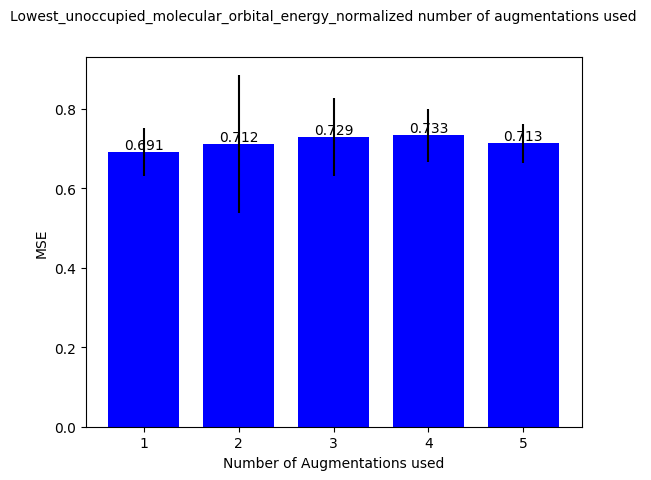

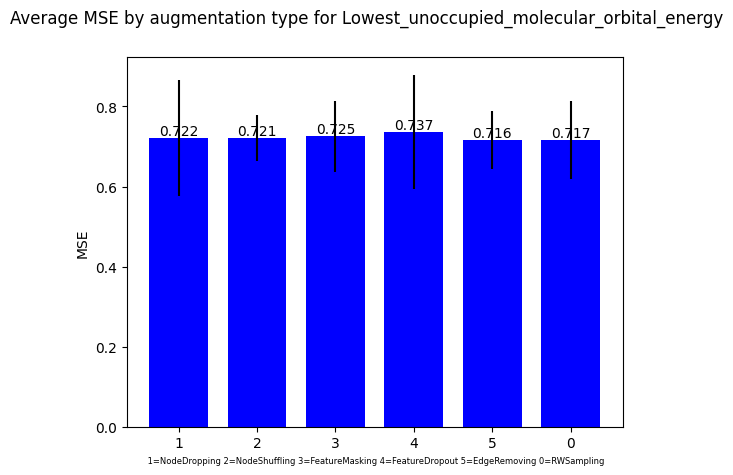

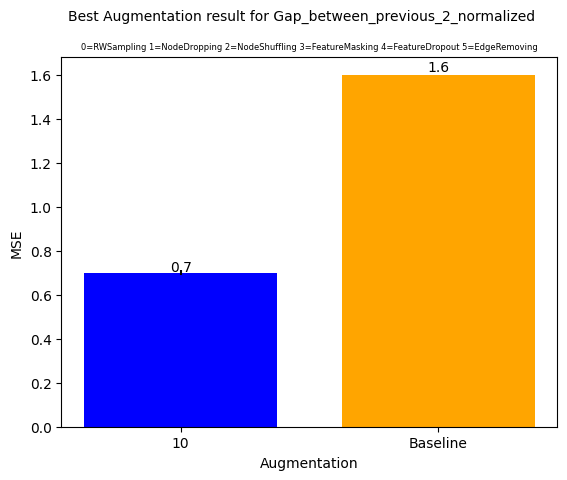

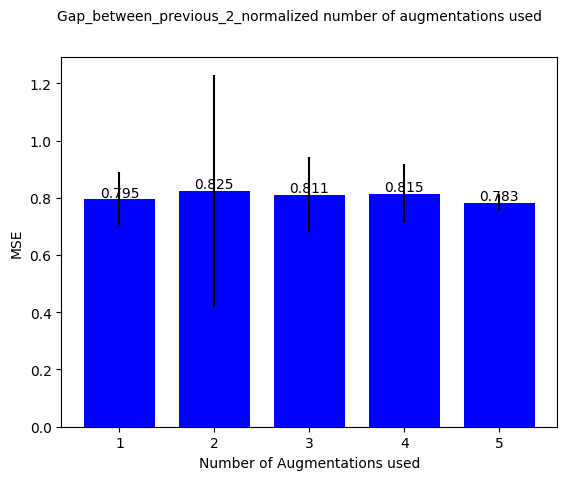

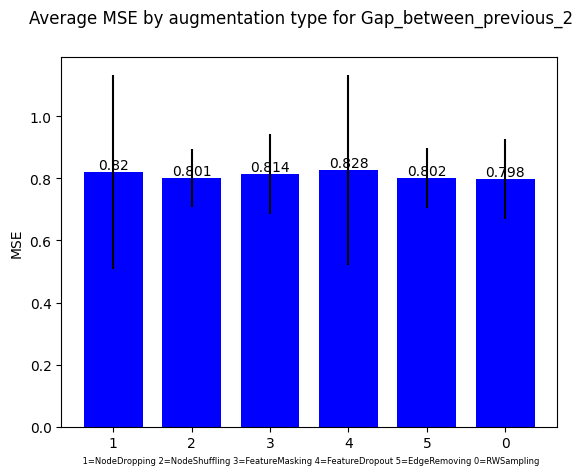

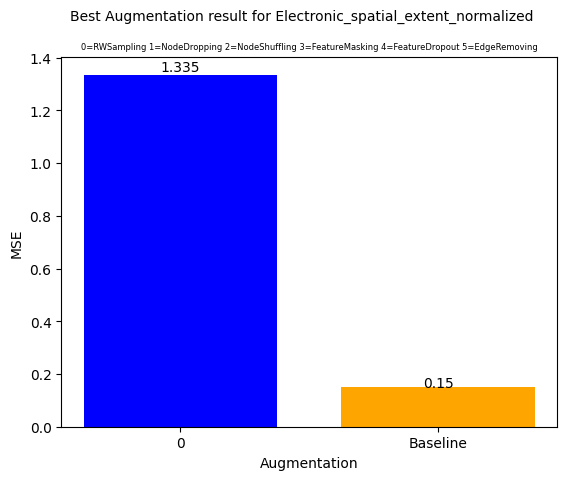

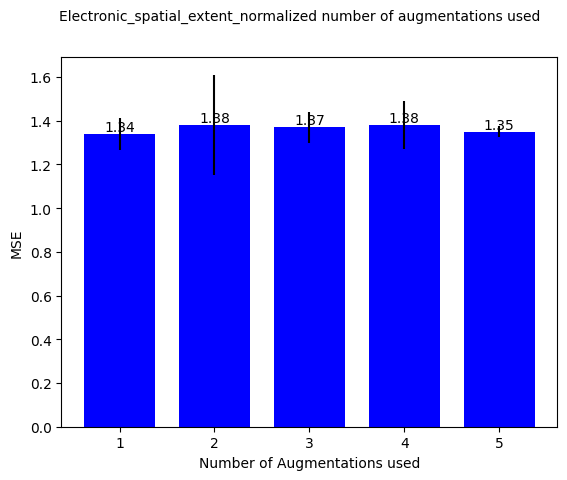

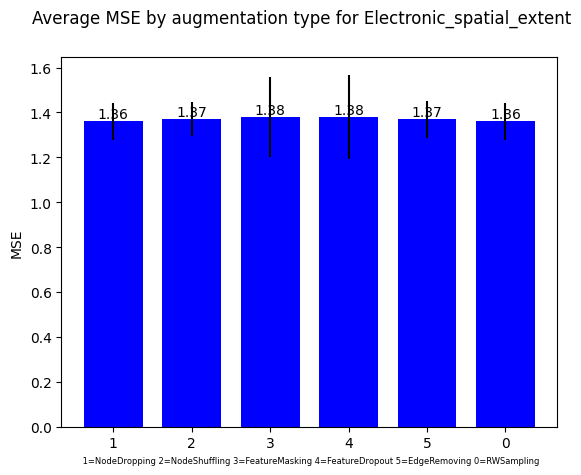

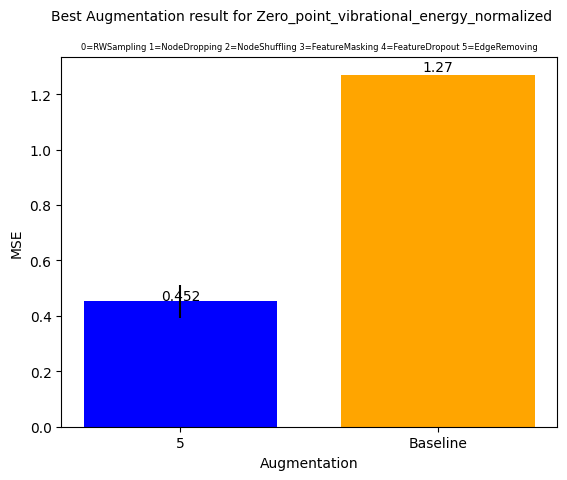

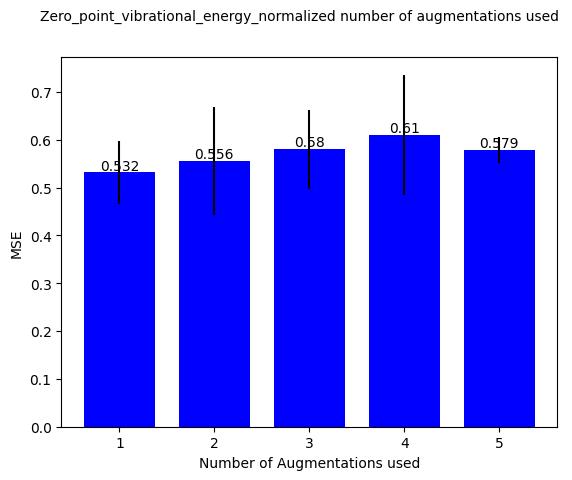

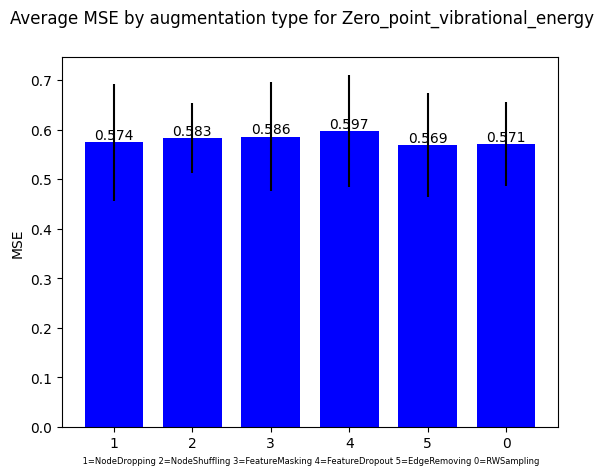

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


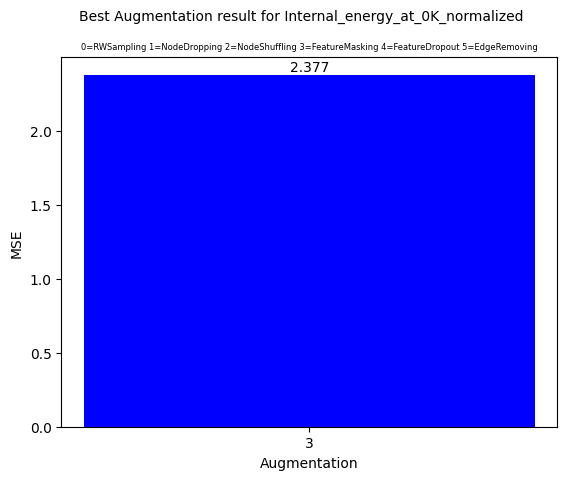

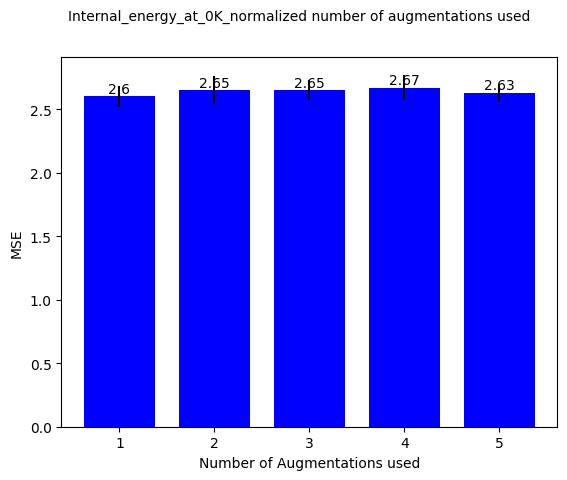

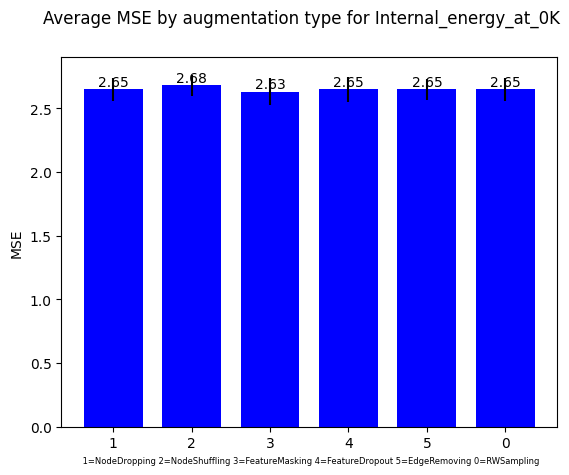

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


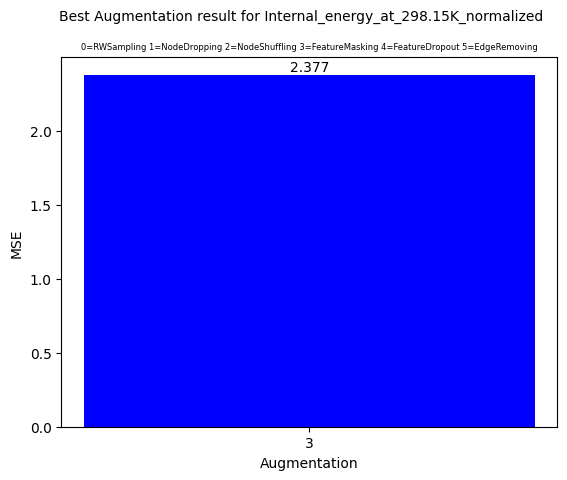

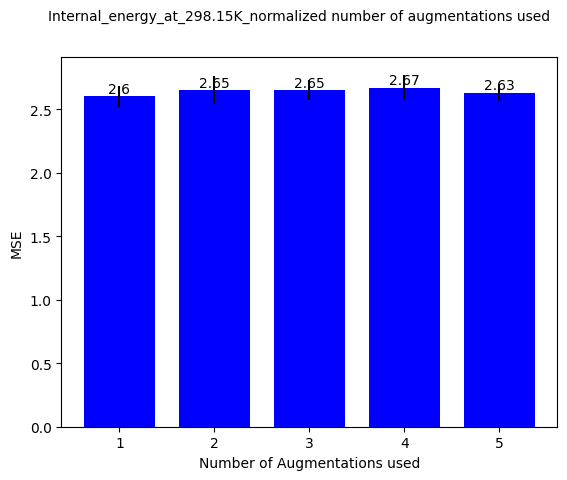

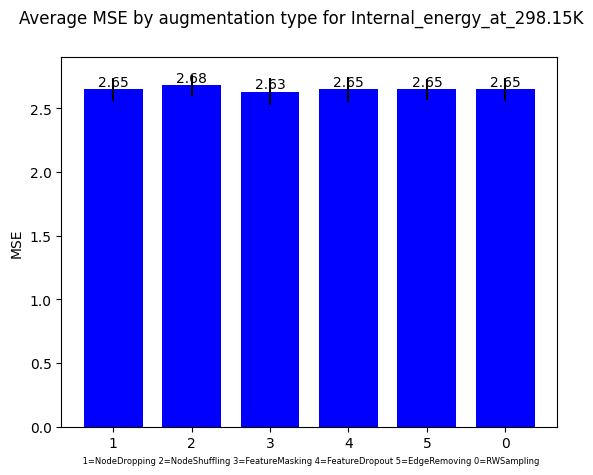

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


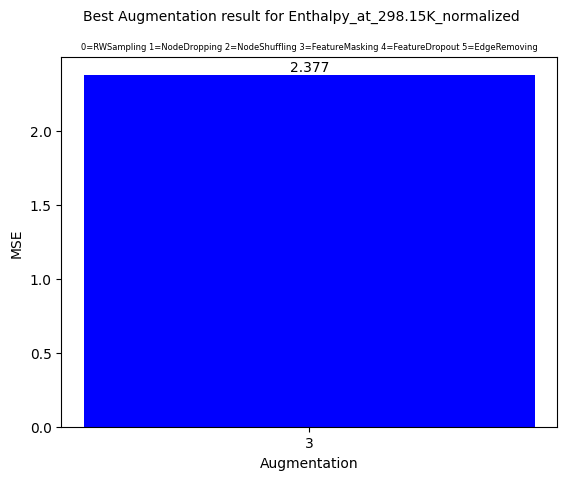

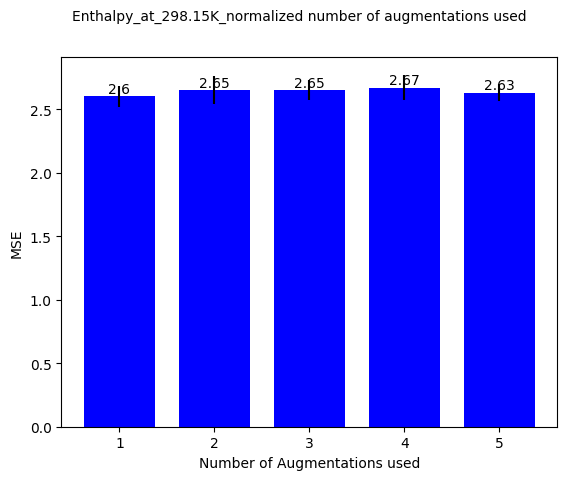

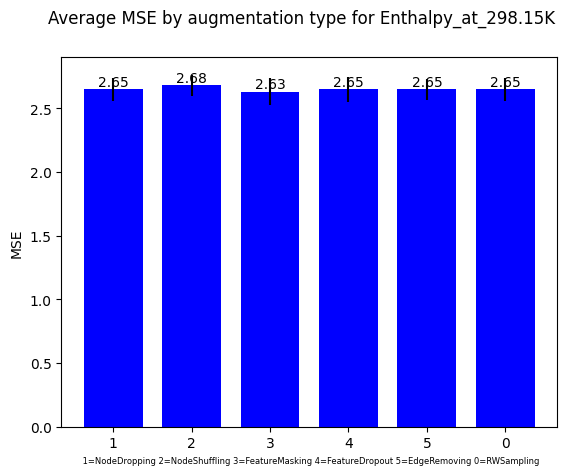

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


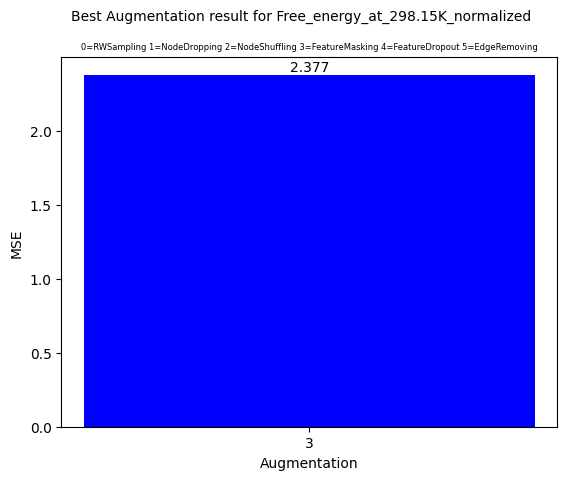

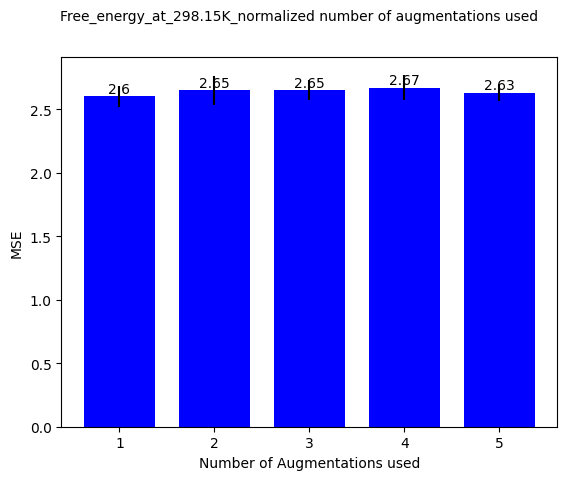

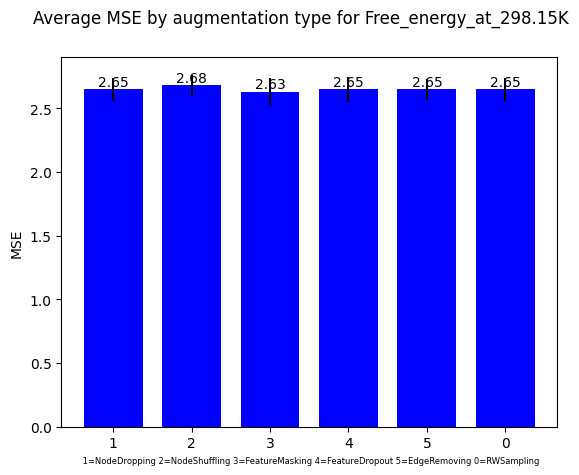

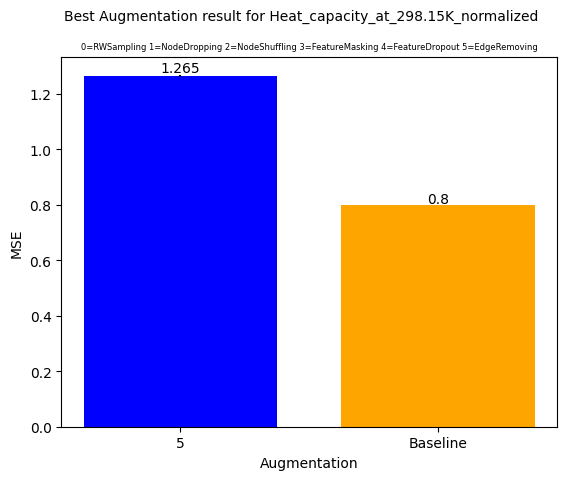

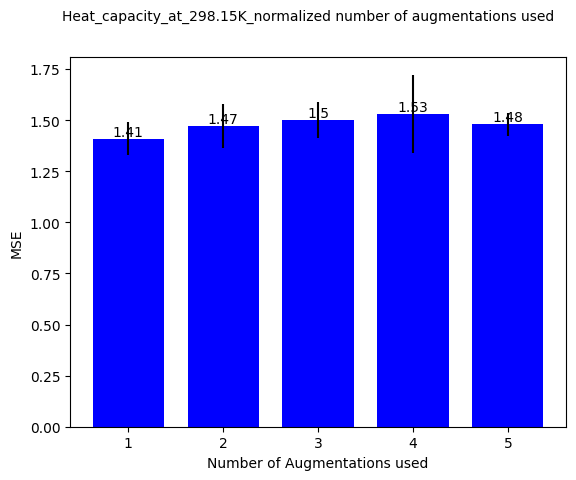

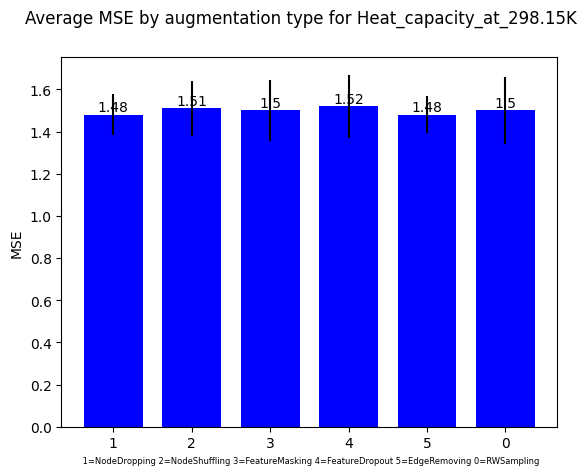

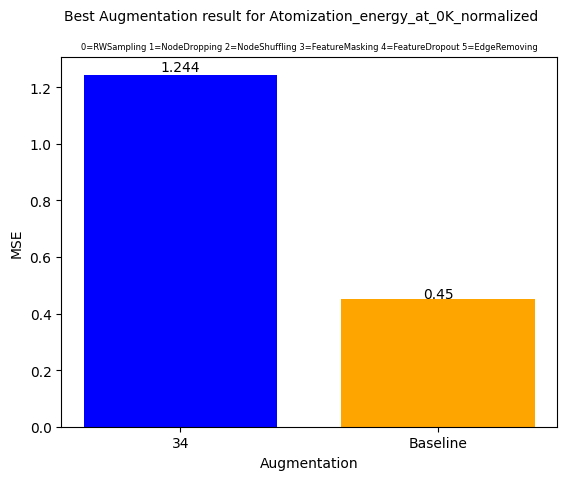

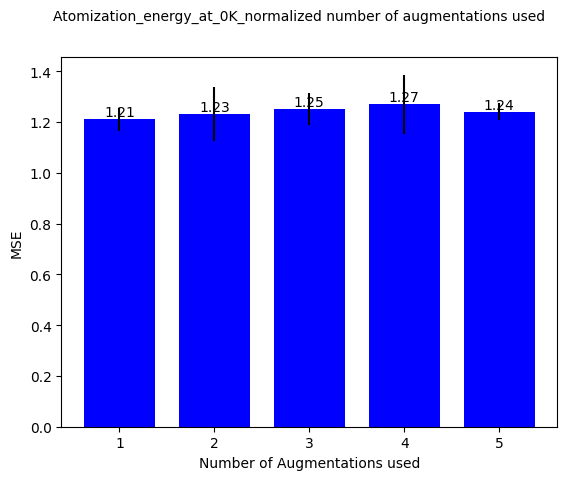

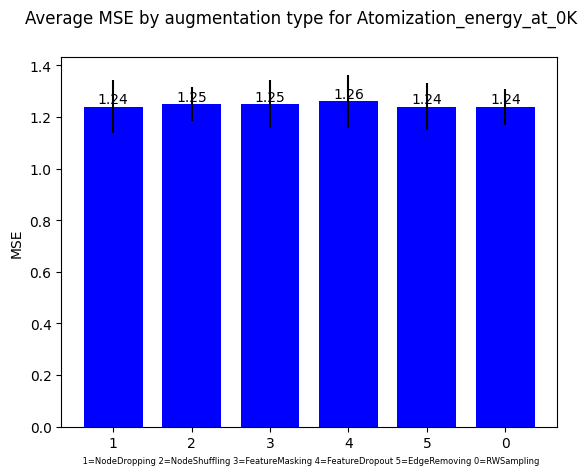

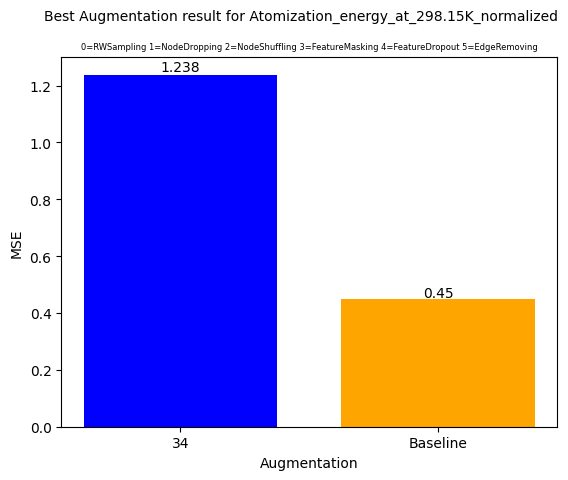

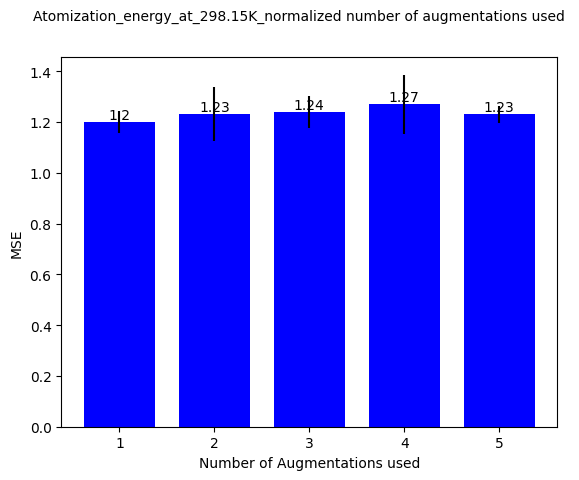

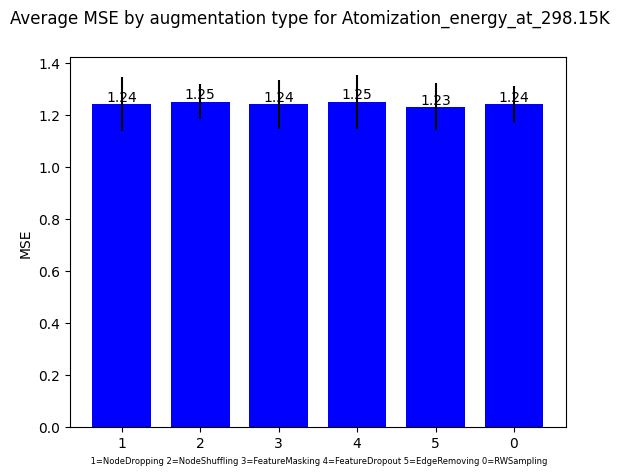

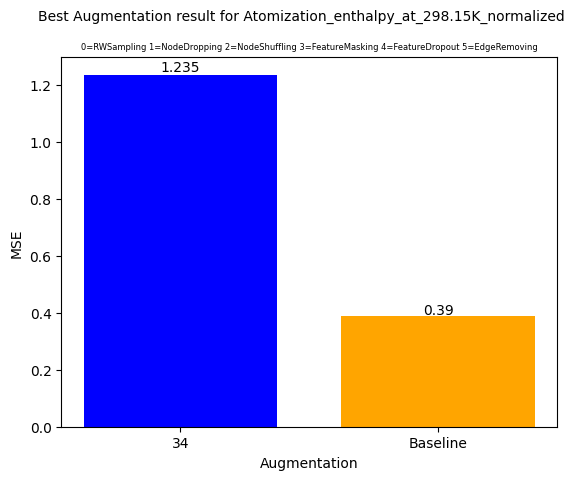

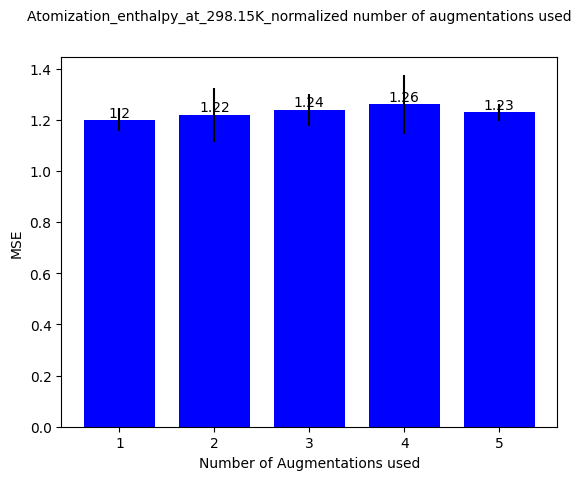

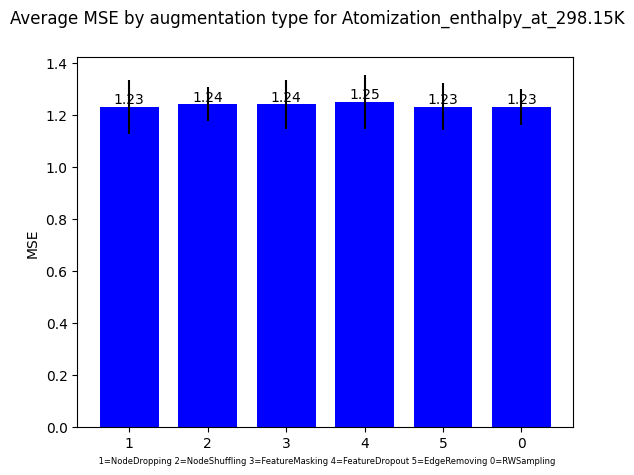

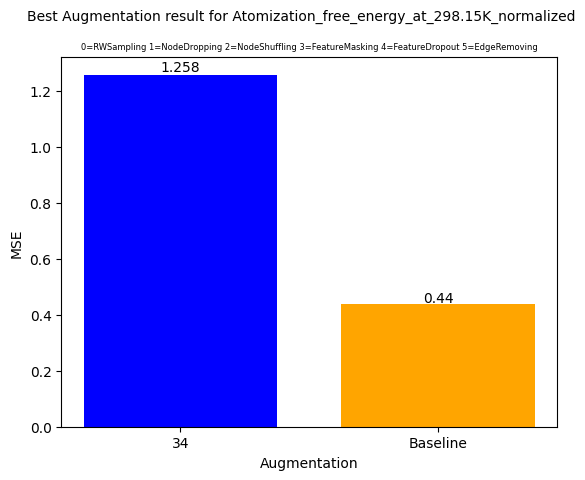

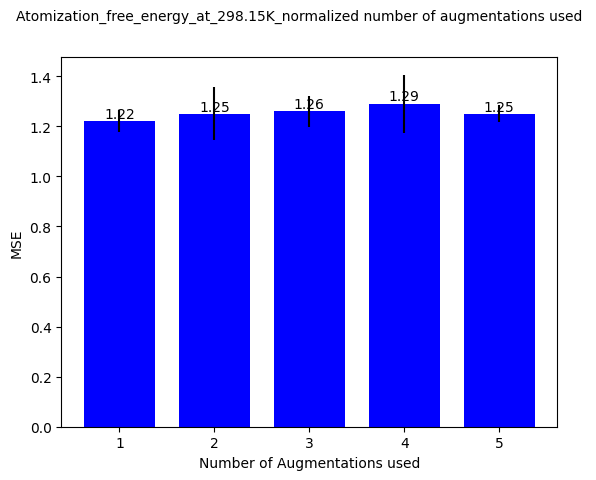

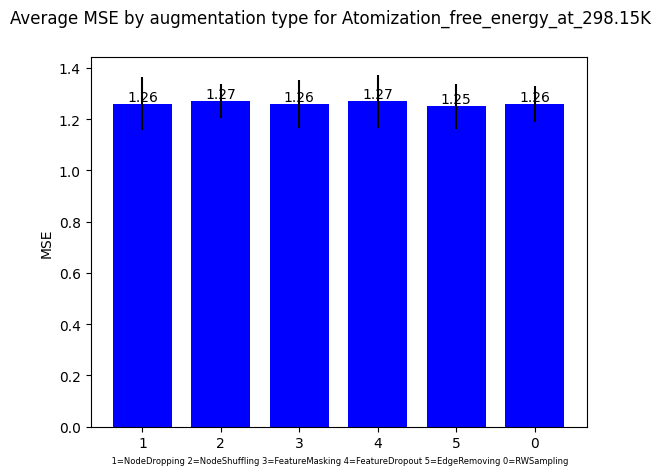

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


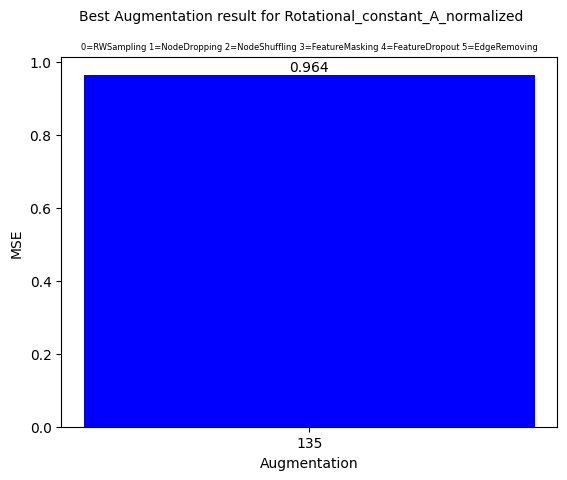

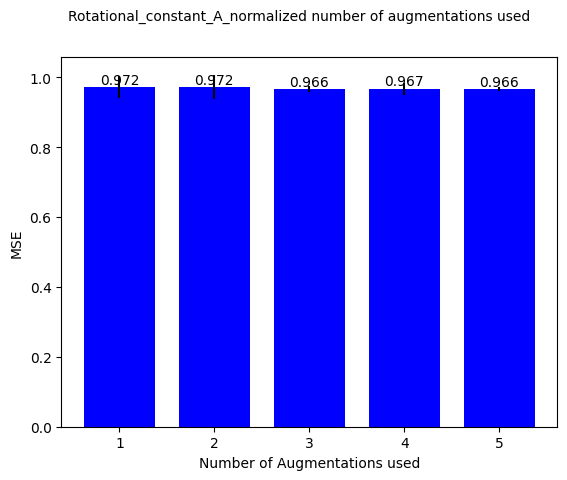

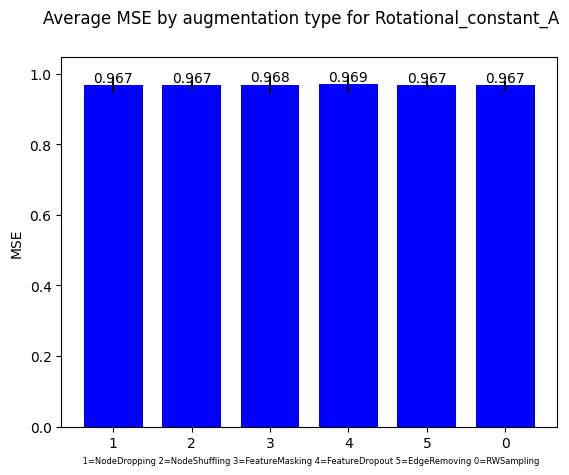

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


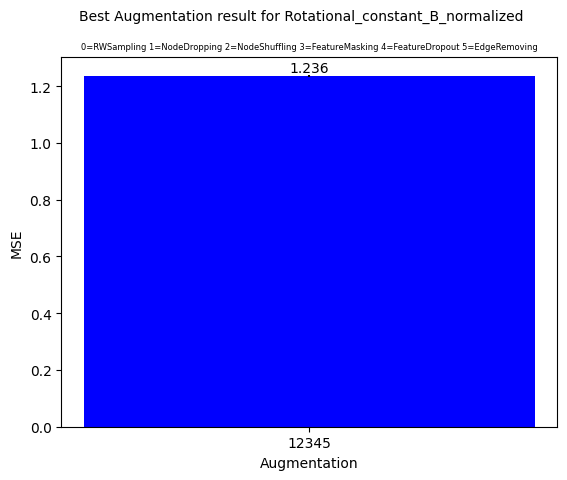

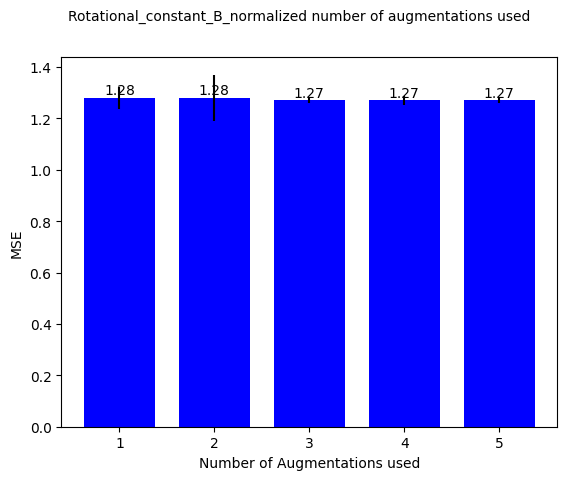

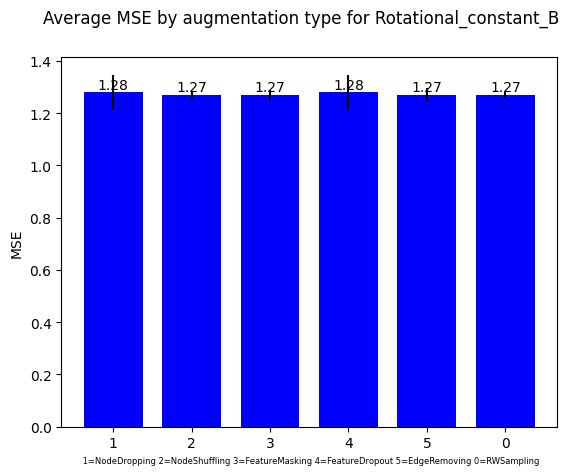

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


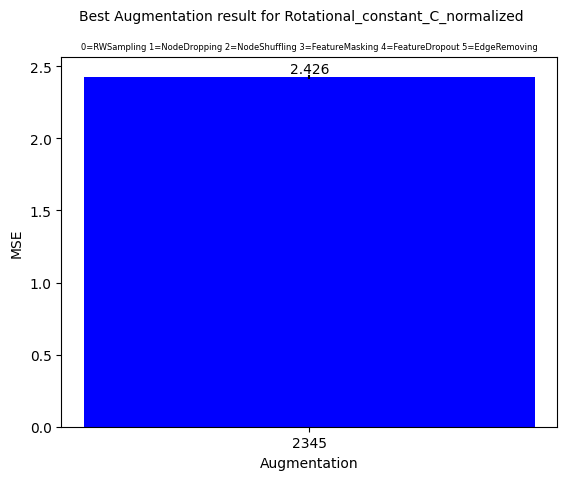

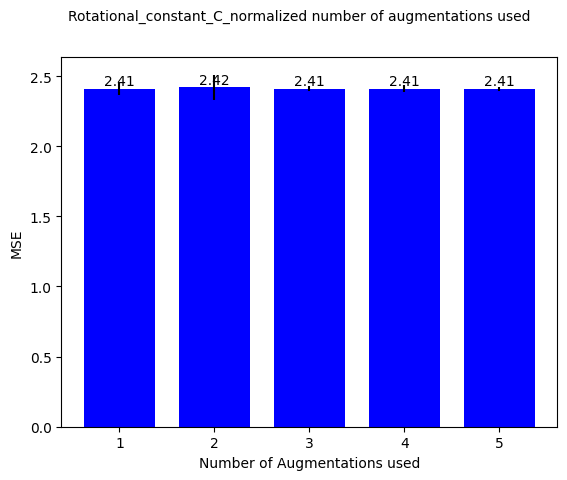

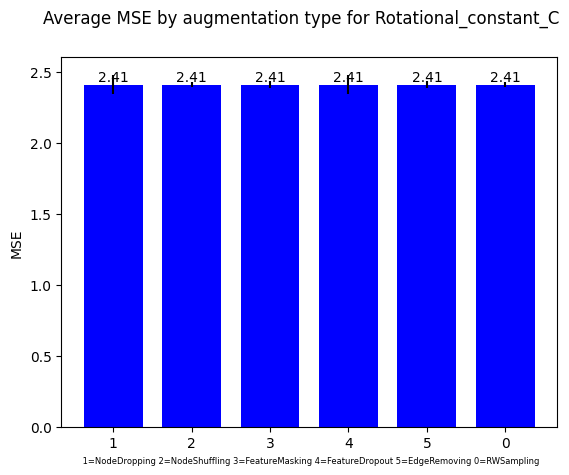

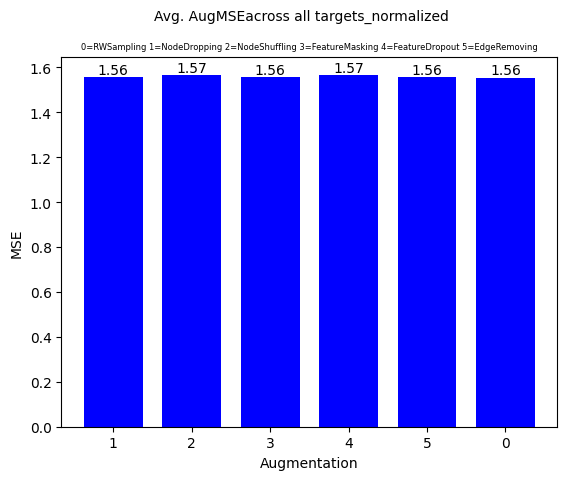

'Finished running avg_by_augmentation_graph!'

In [22]:
avg_by_augmentation_graph(results_df_normalized_mse, augmentations_used, path, 'MSE', '_normalized')

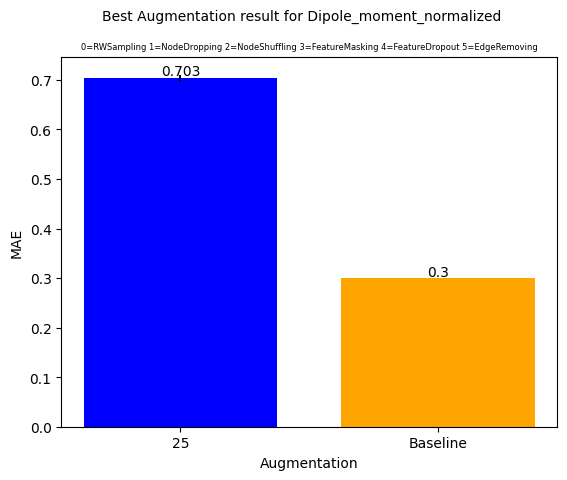

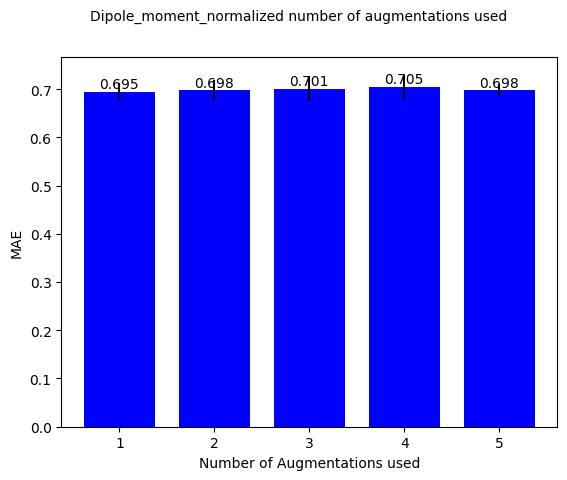

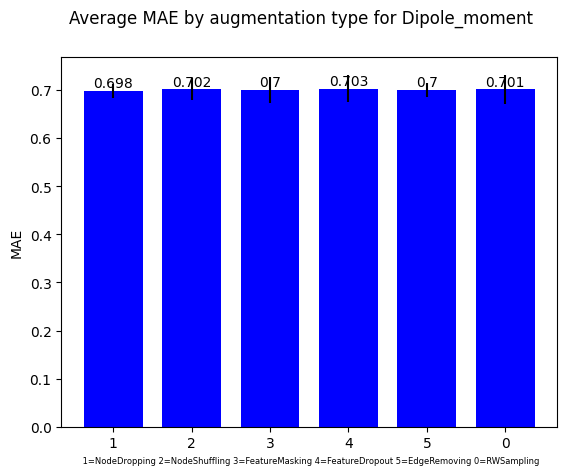

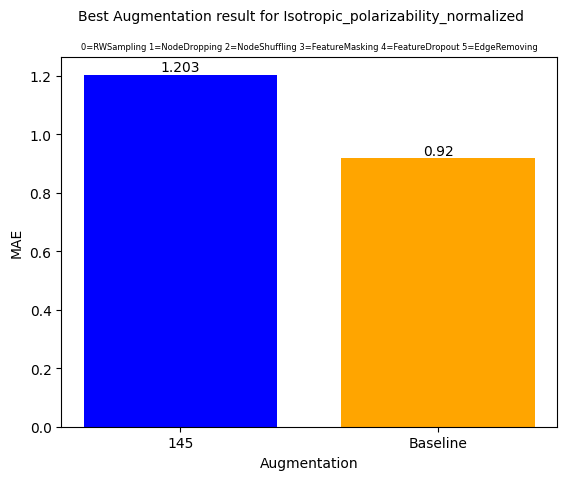

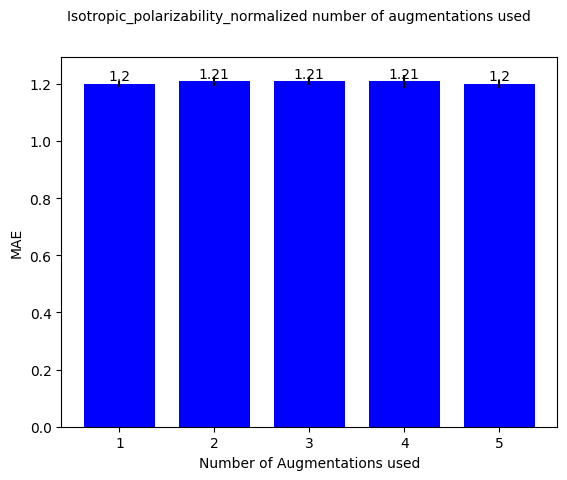

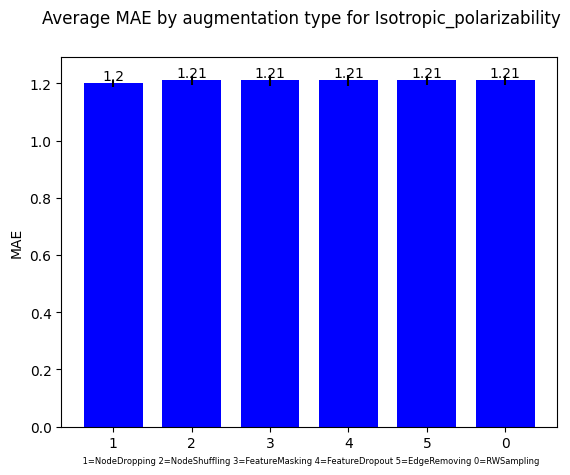

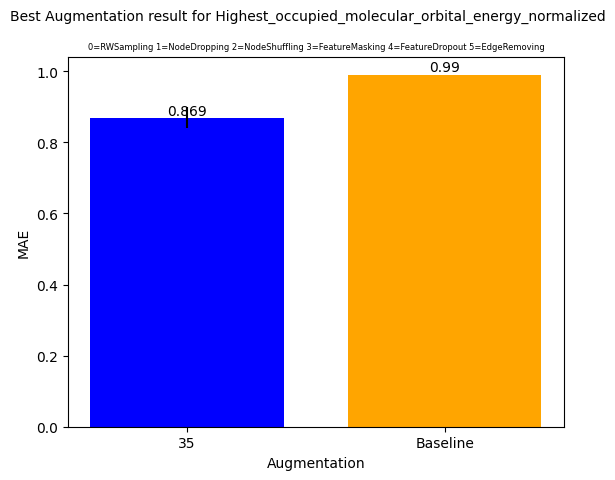

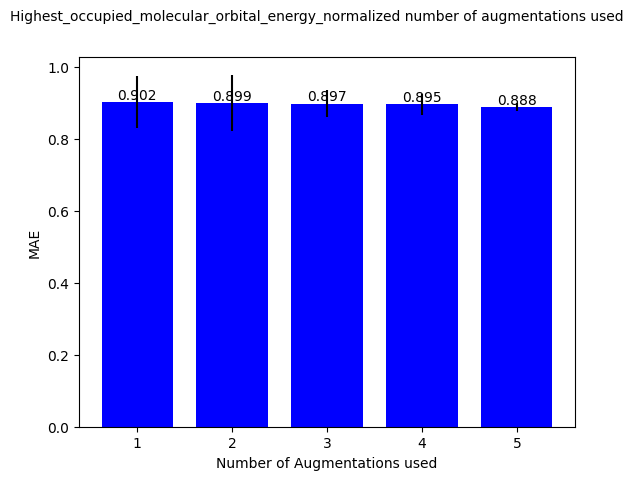

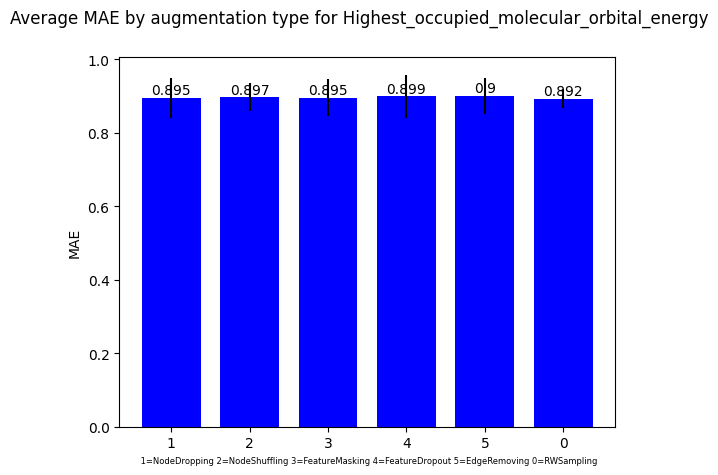

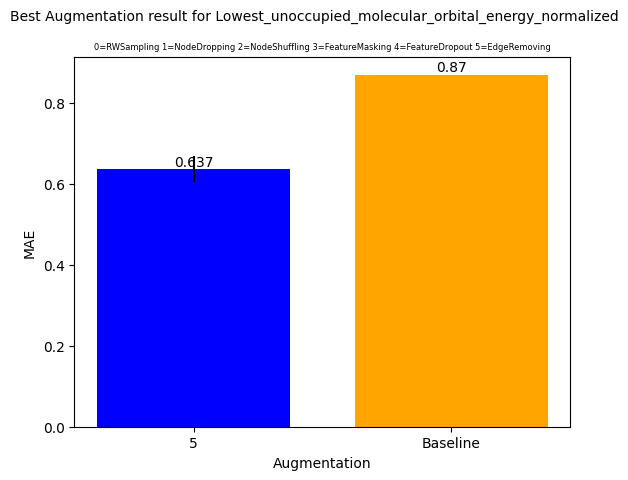

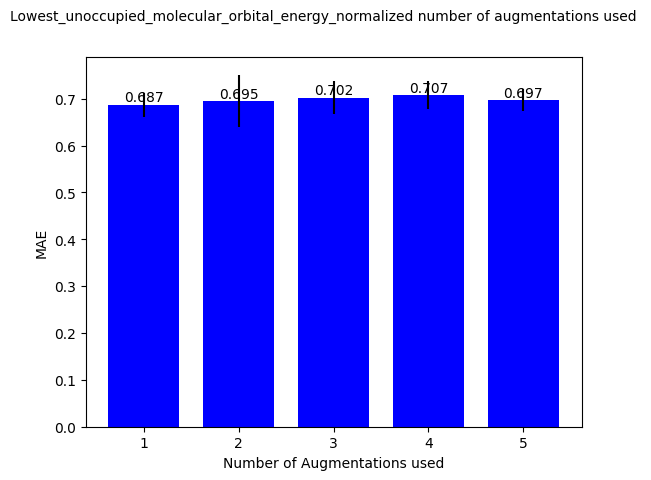

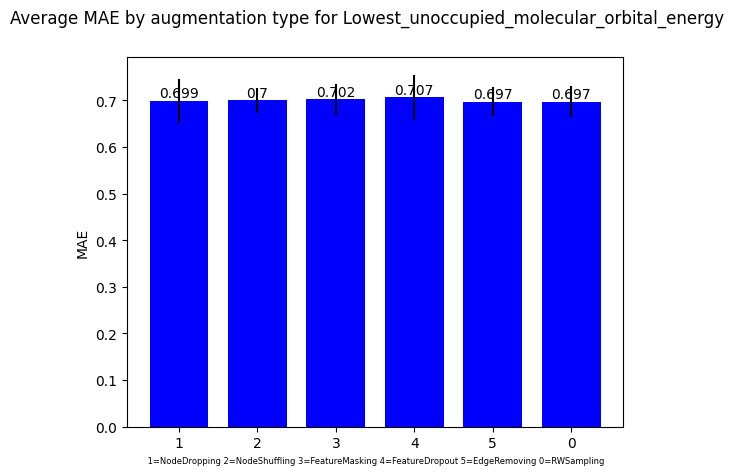

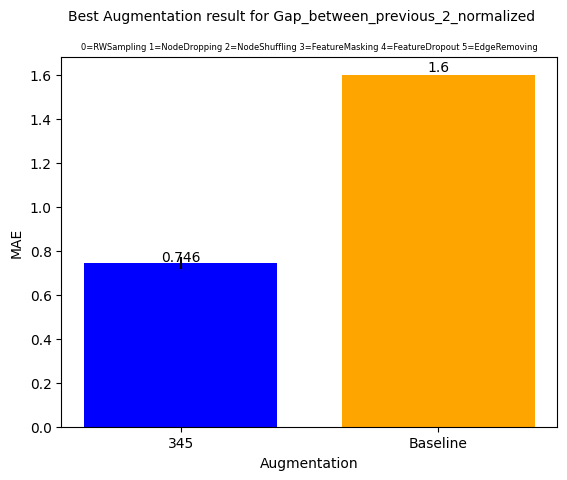

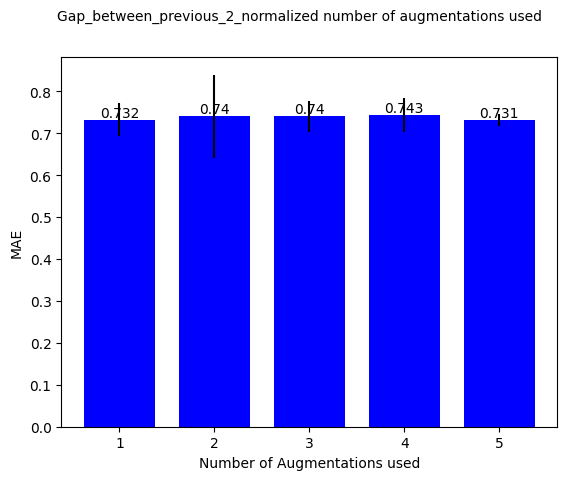

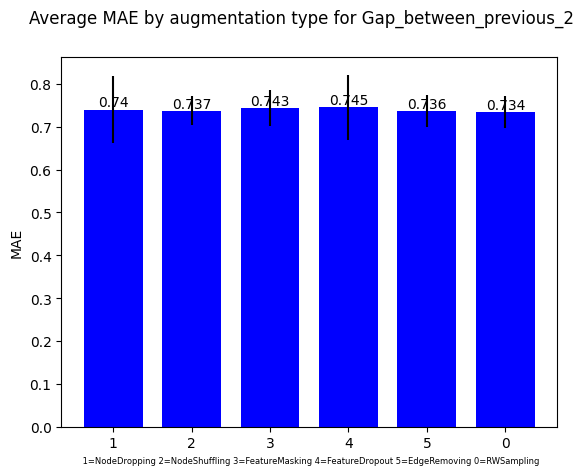

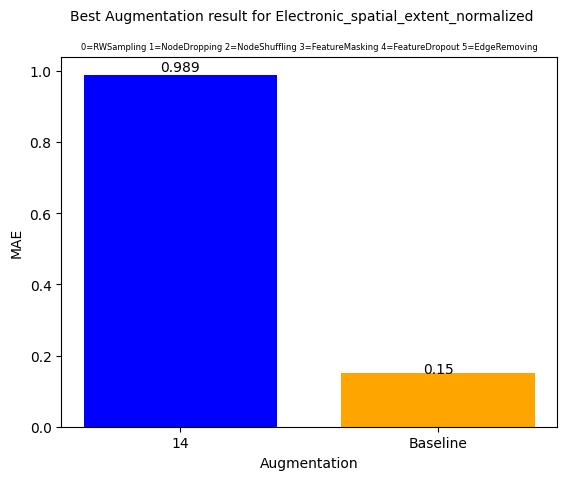

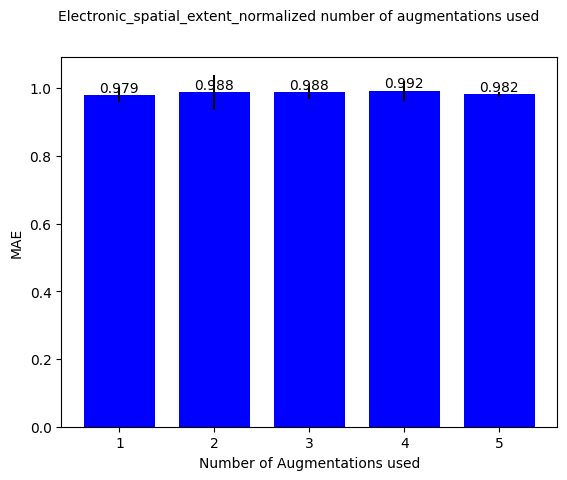

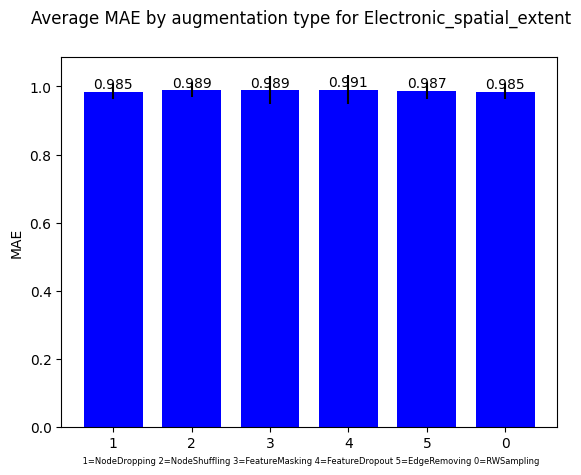

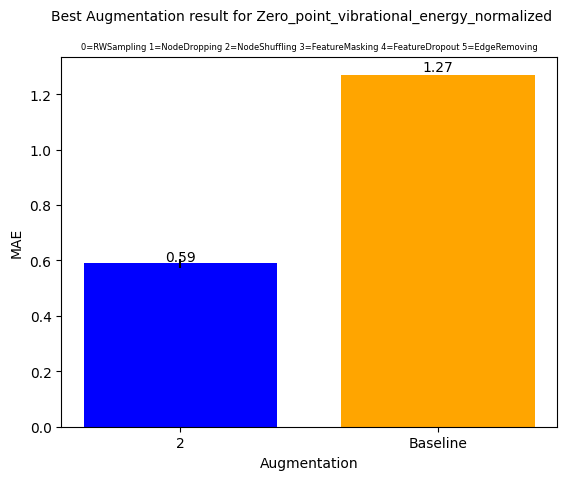

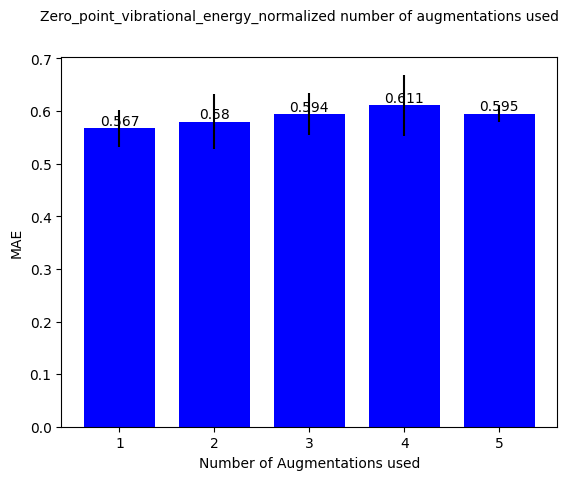

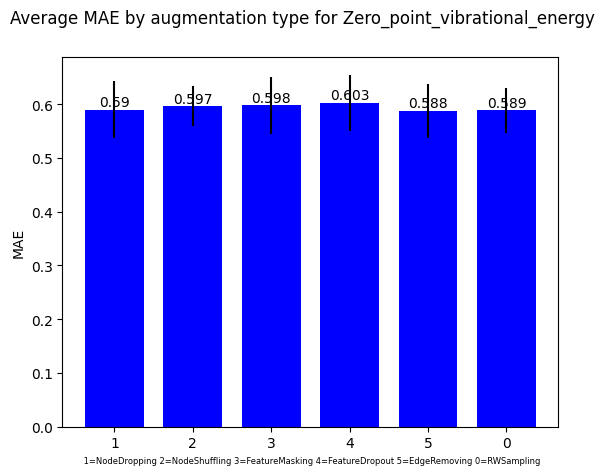

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


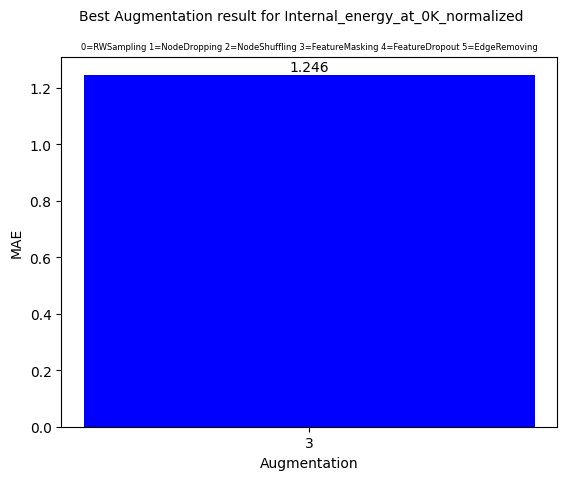

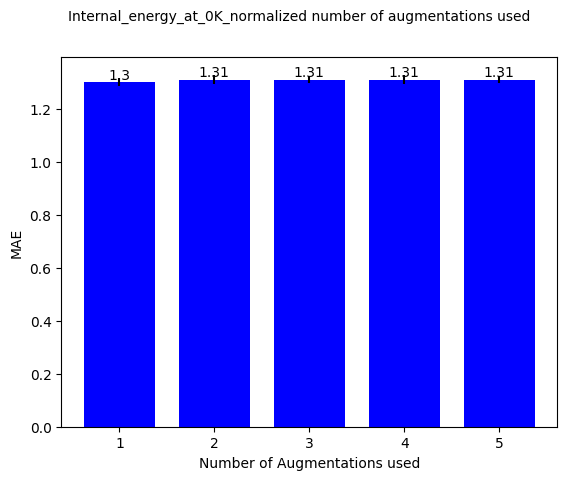

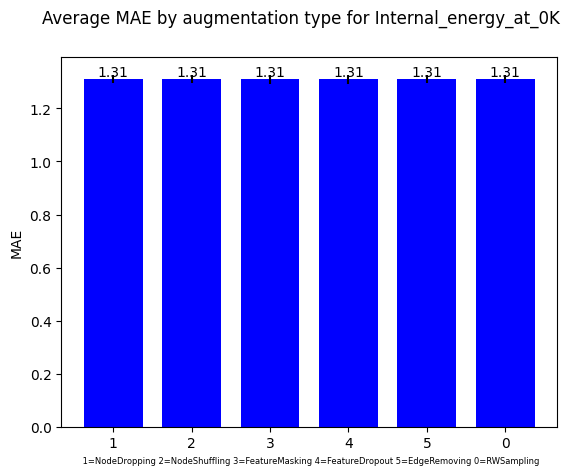

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


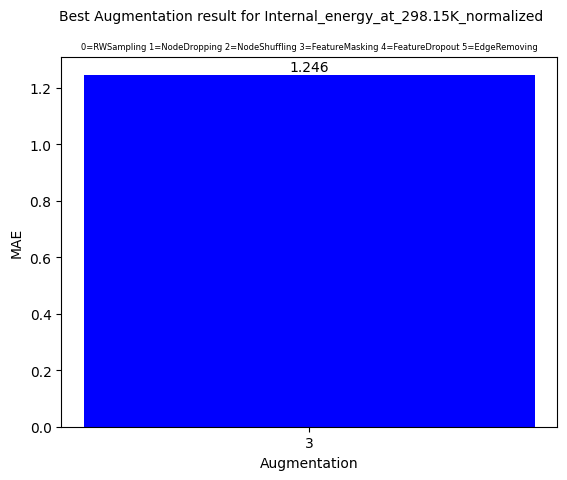

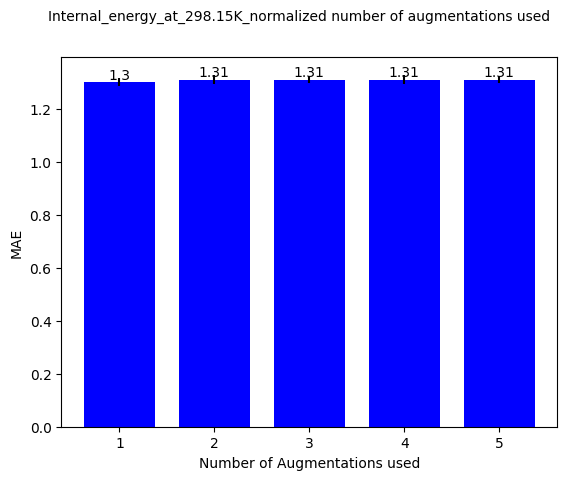

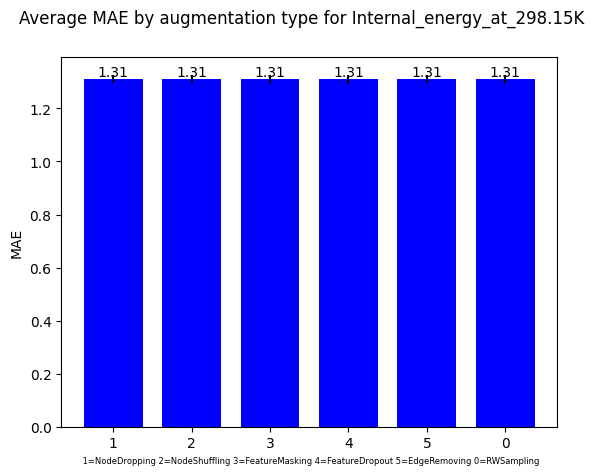

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


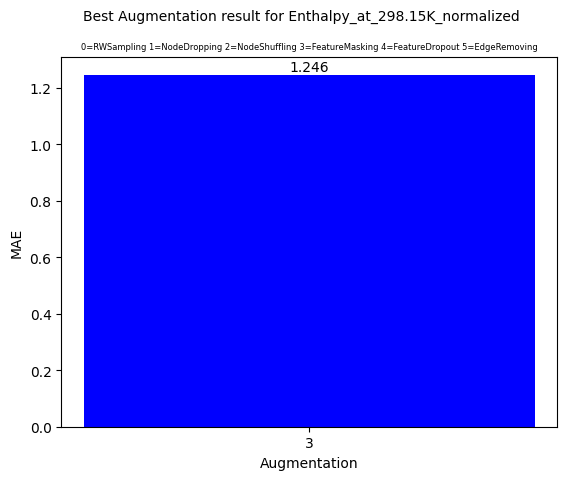

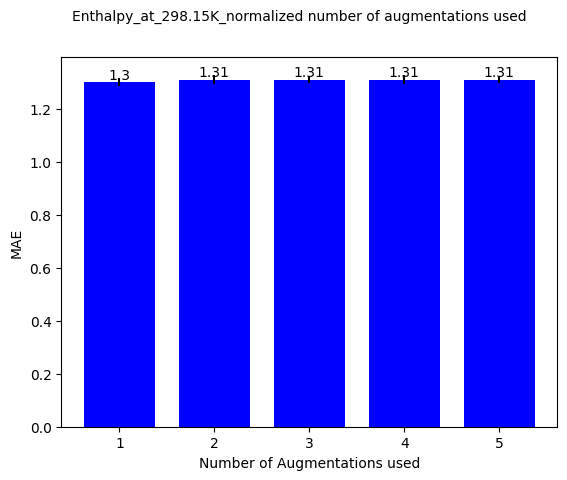

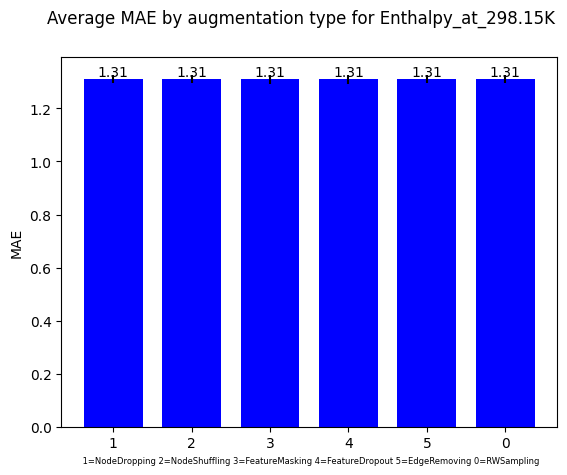

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


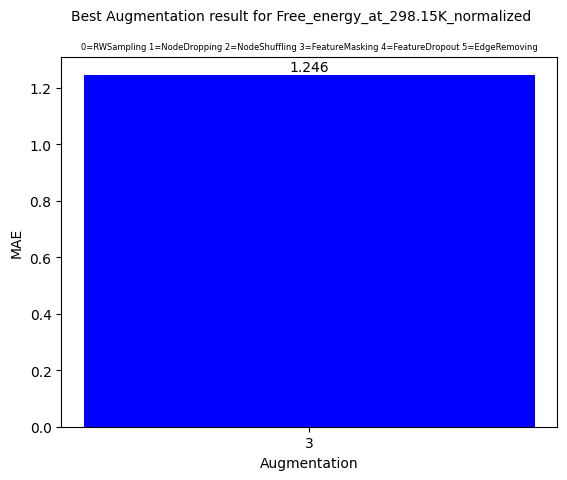

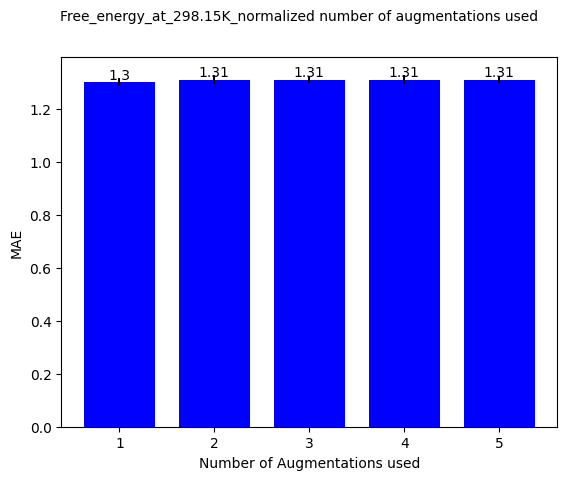

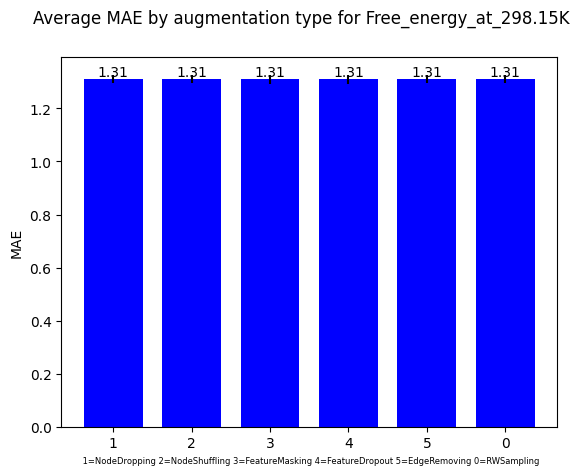

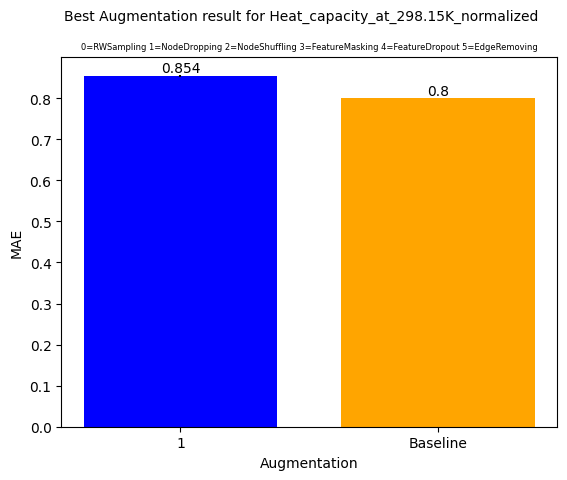

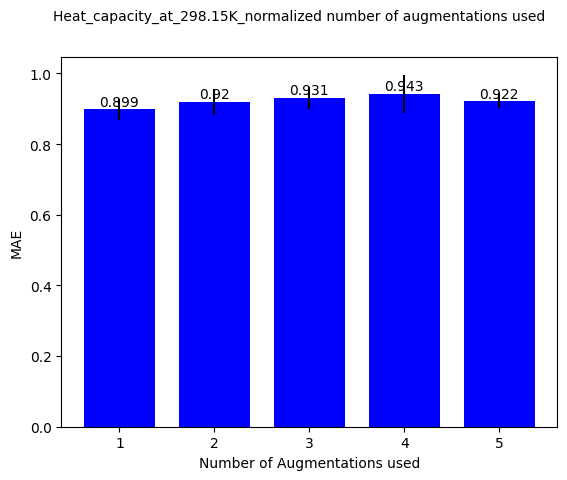

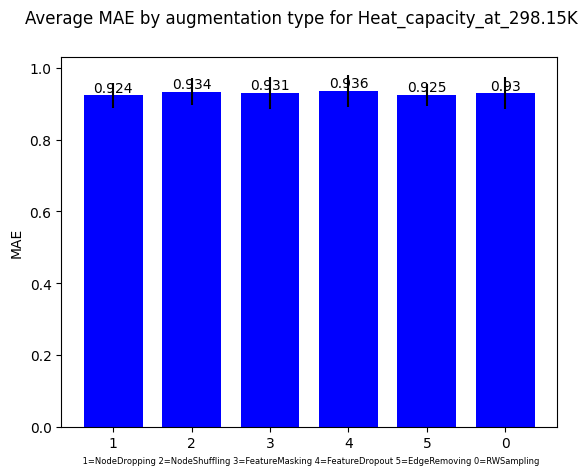

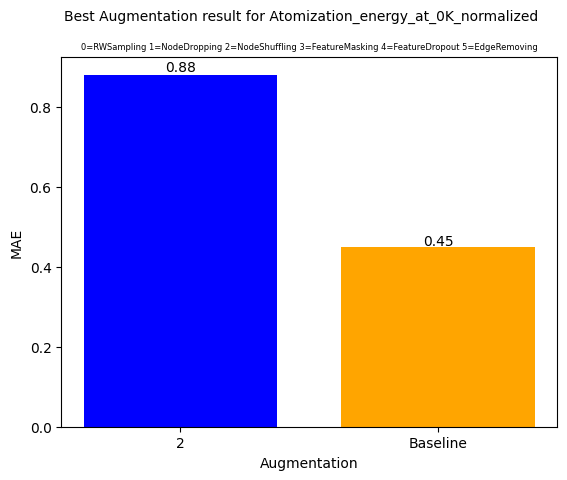

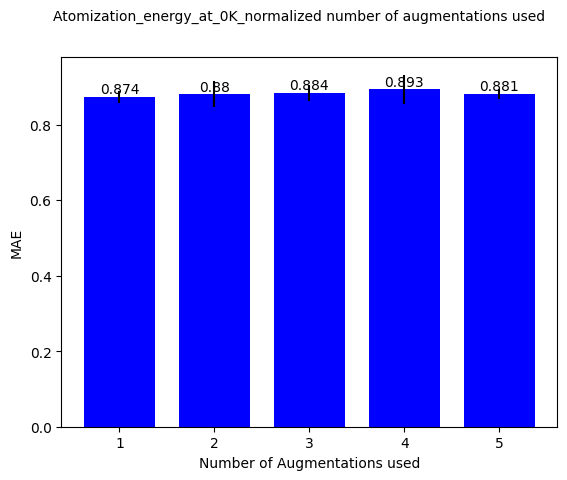

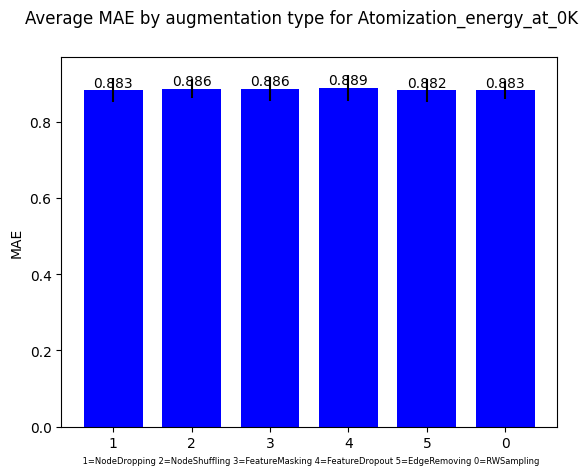

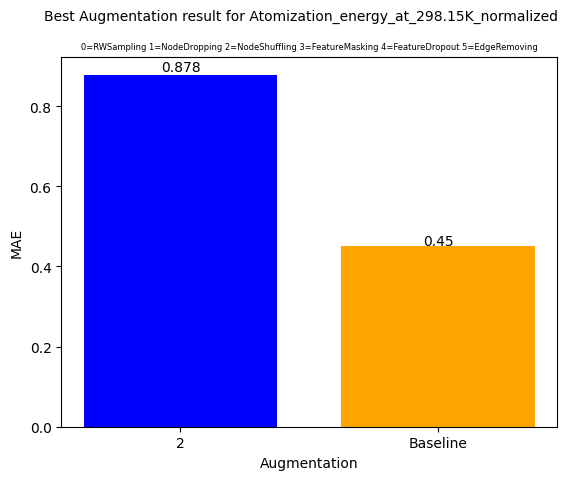

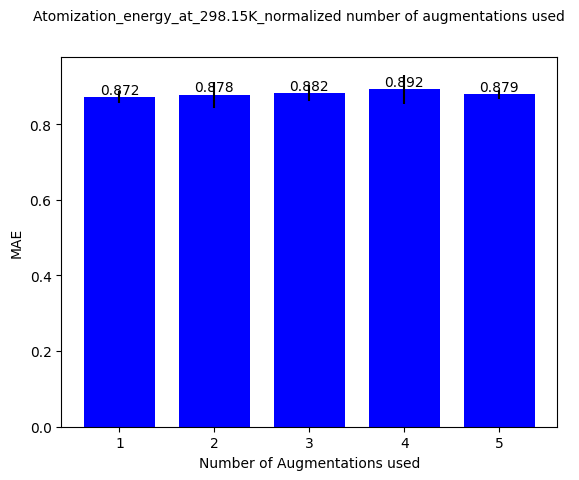

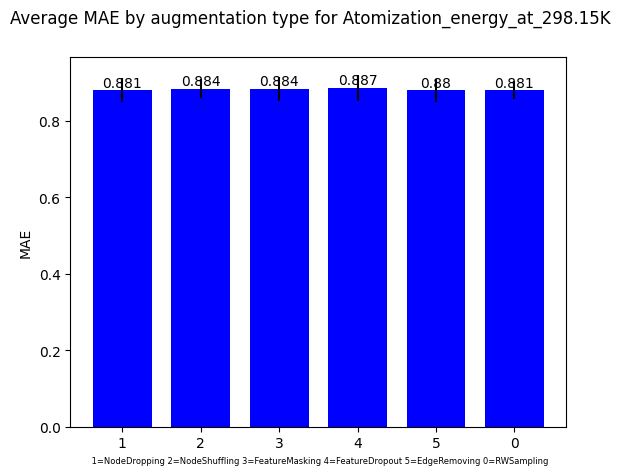

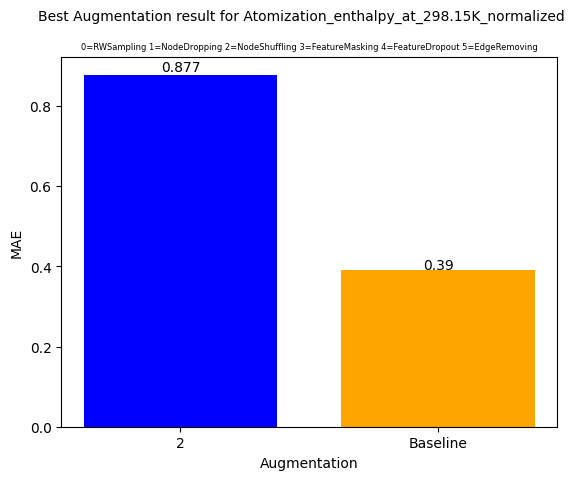

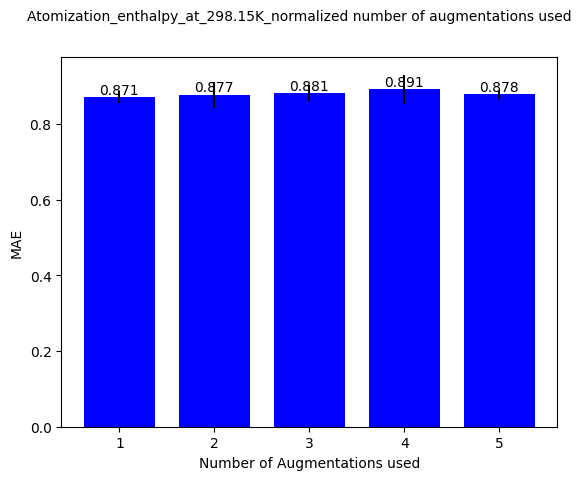

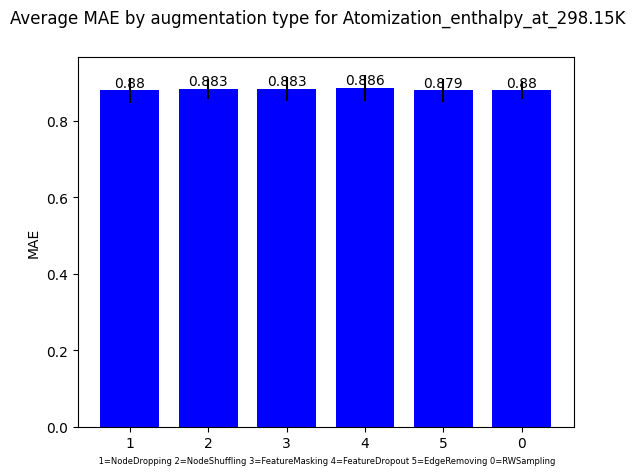

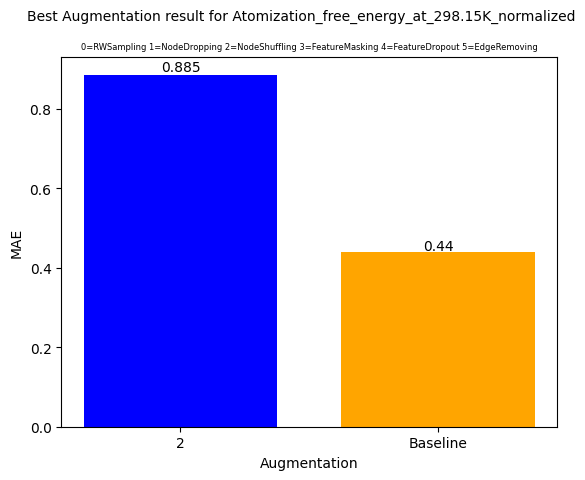

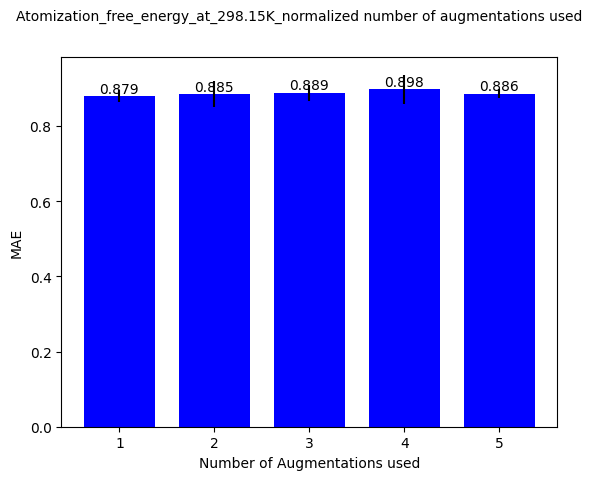

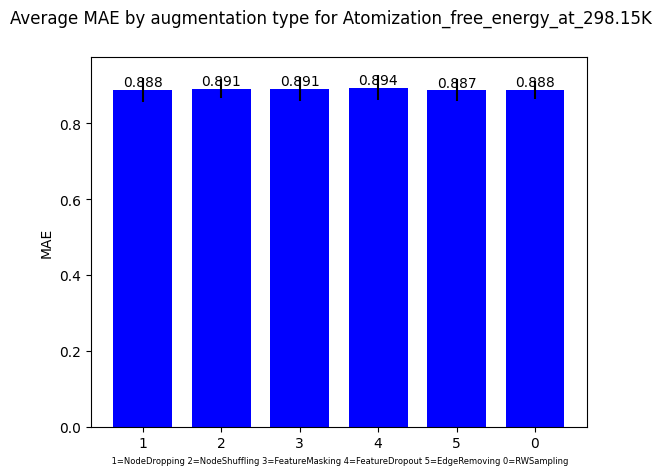

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


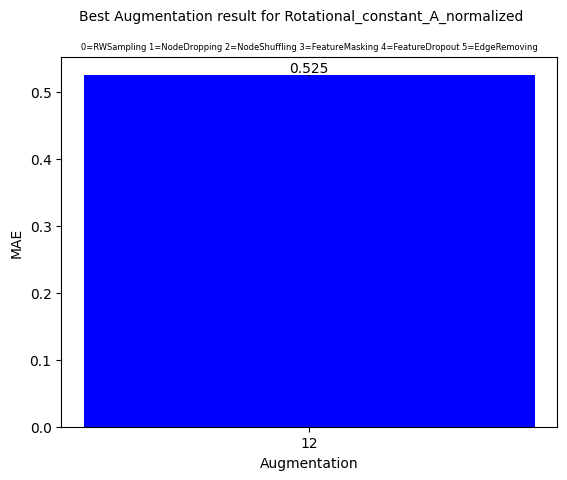

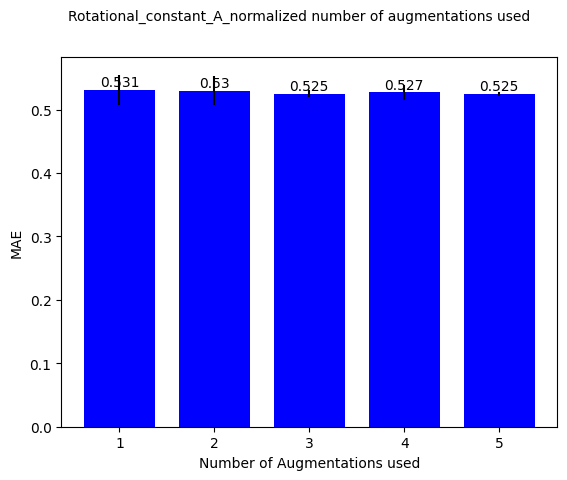

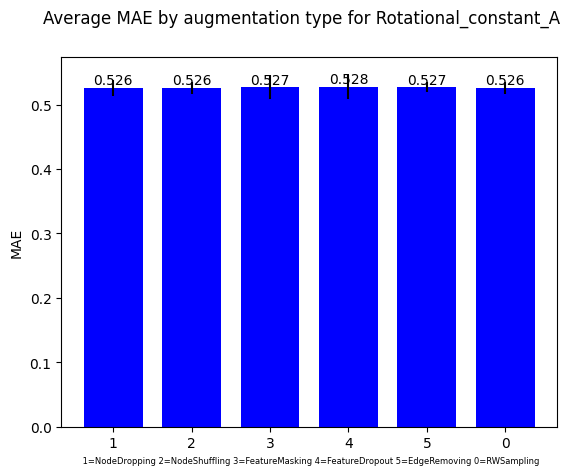

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


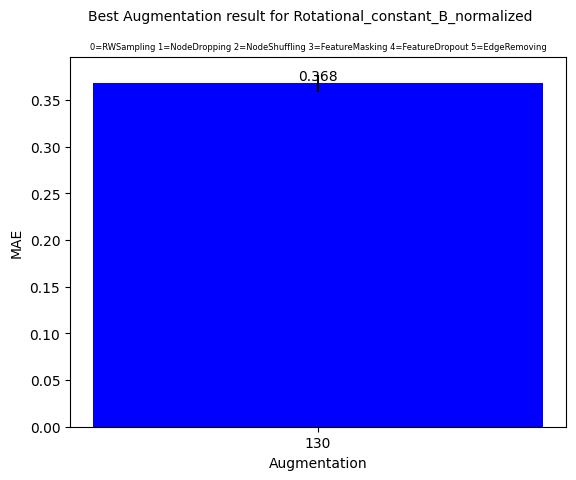

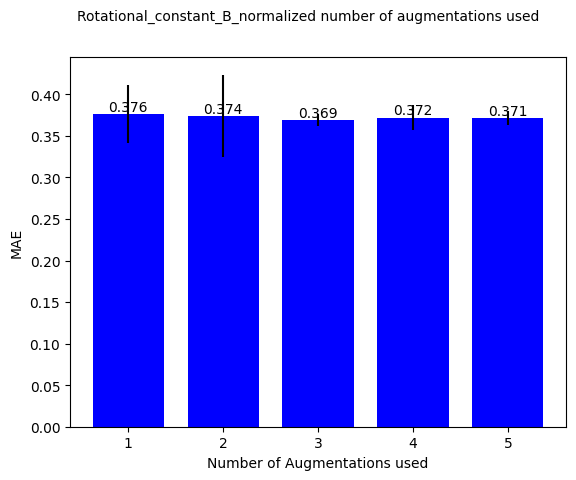

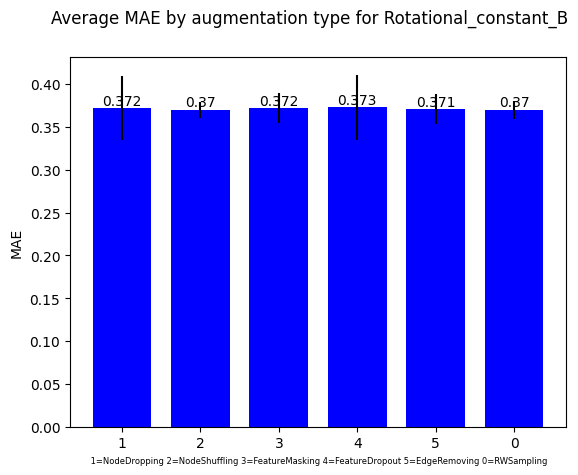

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


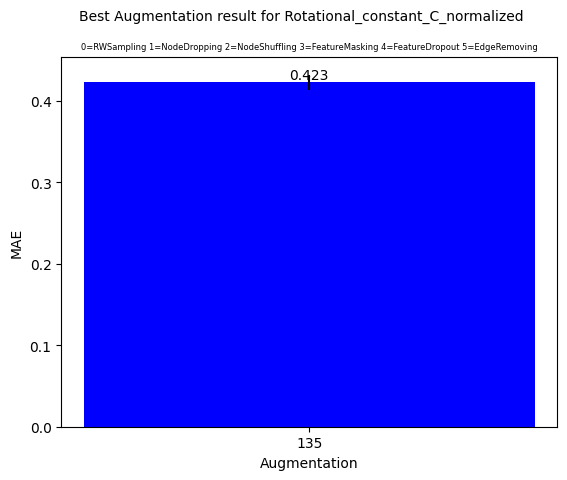

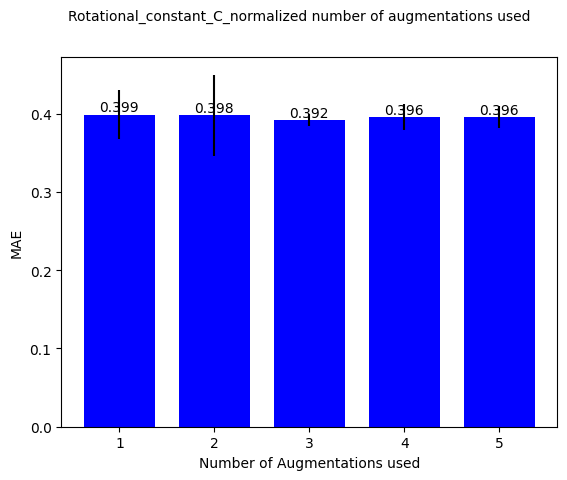

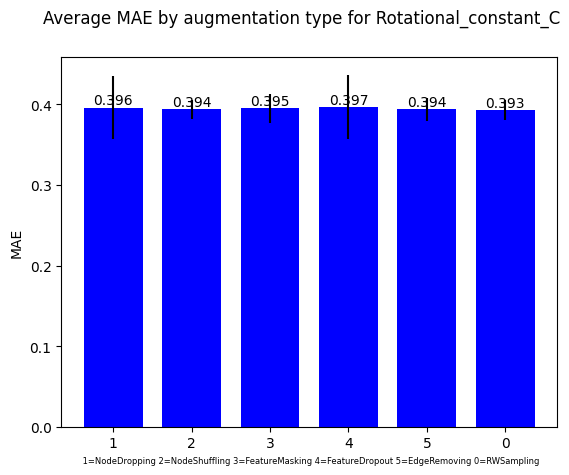

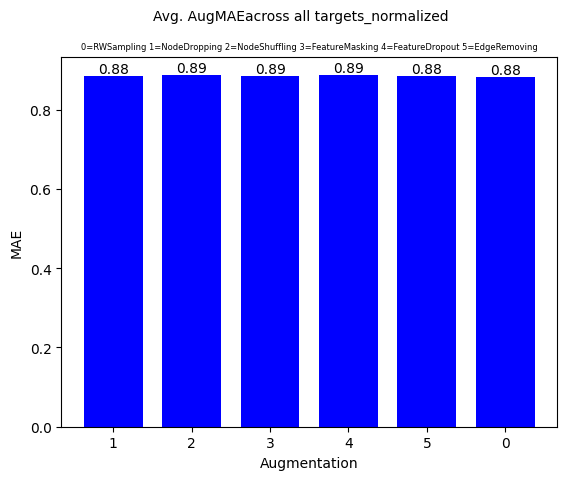

'Finished running avg_by_augmentation_graph!'

In [23]:
avg_by_augmentation_graph(results_df_normalized_mae, augmentations_used, path, 'MAE', '_normalized')

In [ ]:
#avg_by_augmentation_graph(lm_mae_results_df_normalized, augmentations_used, path, 'MAE', '_normalized')
#avg_by_augmentation_graph(rf_mae_results_df_normalized, augmentations_used, path, 'MAE', '_normalized')
#avg_by_augmentation_graph(xgboost_mae_results_df_normalized, augmentations_used, path, 'MAE', '_normalized')
#avg_by_augmentation_graph(lgbm_mae_results_df_normalized, augmentations_used, path, 'MAE', '_normalized')

#avg_by_augmentation_graph(lm_mse_results_df_normalized, augmentations_used, path, 'MSE', '_normalized')
#avg_by_augmentation_graph(rf_mse_results_df_normalized, augmentations_used, path, 'MSE', '_normalized')
#avg_by_augmentation_graph(xgboost_mse_results_df_normalized, augmentations_used, path, 'MSE', '_normalized')
#avg_by_augmentation_graph(lgbm_mse_results_df_normalized, augmentations_used, path, 'MSE', '_normalized')






In [ ]:
#avg_by_augmentation_graph(results_df_normalized, augmentations_used, path, 'MSE_MAE_R2', '_normalized')

In [ ]:
#avg_by_augmentation_graph(all_trials_mae_df_normalized, augmentations_used, path, 'MAE', '_normalized')



In [ ]:
#maybe create a new directory and move the results, r2, etc. into it?
    #would prevent deleting data from a previous run accidentally (if forget to change filenames/filepaths from previous experiment)